In [1]:
# This is a code to estimate the pixels that are within the polygons for each type of vegetation. 
# The AI of the patches is calculated as the 80th percentile of the AI of all the pixels that are forming the patch

In [2]:
import pandas as pd
import numpy as np
import rasterio
import geopandas as gpd
from shapely.geometry import Point
from rasterio.crs import CRS

import matplotlib.pyplot as plt

In [3]:
#This is the code to get the coordinates of the raster's pixels in a dataframe

def pixels2points (dataset, polygon):
    val = dataset.read(1) # band 1
    geometry = [Point(dataset.xy(x,y)[0],dataset.xy(x,y)[1]) for x,y in np.ndindex(val.shape) if val[x,y] != -999999]
    v = [val[x,y] for x,y in np.ndindex(val.shape) if val[x,y] != -999999]
    df = gpd.GeoDataFrame({'geometry':geometry,'data':v})
    df.crs = polygon.crs
    return df

In [4]:
# This is a code to calculate the 80th percentile of the AI and the Area of the pixels that are within a specific polygon

def AI_pixels_within_polygon(df_match):
    
    AI_percentile_list = []
    Area_list = []
    Poly_ID_array = df_match['ID'].unique() # This is an array with all polygons ID that contain points
    Patch_ID_list = []
    
    
    for ii in Poly_ID_array:
       
        part = df_match.loc[df_match['ID'] ==ii]
        percentile = np.percentile(part['data'],80)
        AI_percentile_list.append (percentile)
        Area_list.append(len(part))
        Patch_ID_list.append(ii)
    
    
    df= pd.DataFrame()
    df['AI (patch)']=AI_percentile_list
    df['Area_Ha (patch)'] = Area_list
    df['ID (patch)'] = Patch_ID_list
   
    
    return  df

In [5]:
# This function is to create a dataframe with the number of polygons or patches that are in categories 0, 1 and 2.

def category (df_in):
    #Patch info
    number_patch_list= []
    #Polygons info
    number_poly_list=[]
    #Common info
    cat_list = []
    #Analyze the AI of the patches and polygons
    ##Category 0
    number_patch_list.append(df_in[df_in['AI (patch)'] >0.90 ].count()[0])
    number_poly_list.append(df_in[df_in['AI'] >0.90 ].count()[0])
    cat_list.append(0)
    ##Category 1
    number_patch_list.append(df_in[(0< df_in['AI (patch)']) & (df_in['AI (patch)']<=0.90)].count()[0])
    number_poly_list.append(df_in[(0< df_in['AI']) & (df_in['AI']<=0.90)].count()[0])
    cat_list.append(1)
    ## Category 2
    number_patch_list.append(df_in[df_in['AI (patch)'] ==0 ].count()[0])
    number_poly_list.append(df_in[df_in['AI'] ==0 ].count()[0])
    cat_list.append(2)
    
    df_out = pd.DataFrame()
    df_out['Category'] = cat_list
    df_out['Number patches'] = number_patch_list
    df_out['Number polygons'] = number_poly_list
    
    return df_out

In [6]:
# This is a code to calculate the category of the AI. 
#Use this function with the dataframe in which there is the info about the pixels and the polygons

def category_calculation (df,text1, text2):

    fuel_list = []
    cat_0_list = []
    cat_1_list = []
    cat_2_list = []
    
    if text1 == 'patch':
        cat_2 = df[df['AI (patch)'] ==0 ].count()[0]
        cat_1 = df[(0< df['AI (patch)']) & (df['AI (patch)']<=0.90)].count()[0]
        cat_0 = df[df['AI (patch)'] >0.90 ].count()[0]
        total = cat_2 + cat_1 + cat_0
        
        cat_2_list.append(cat_2/total*100)
        cat_1_list.append(cat_1/total*100)
        cat_0_list.append(cat_0/total*100)
    
    if text1 == 'polygon':
        cat_2 = df[df['AI'] ==0 ].count()[0]
        cat_1 = df[(0< df['AI']) & (df['AI']<=0.90)].count()[0]
        cat_0 = df[df['AI'] >0.90 ].count()[0]
        total = cat_2 + cat_1 + cat_0
        
        cat_2_list.append(cat_2/total*100)
        cat_1_list.append(cat_1/total*100)
        cat_0_list.append(cat_0/total*100)
    
    fuel_list.append(text2)
    
    df_new = pd.DataFrame()
    df_new['Fuel'] = fuel_list
    df_new['Category 0'] = cat_0_list
    df_new['Category 1'] = cat_1_list
    df_new['Category 2'] = cat_2_list
    
    return df_new

In [7]:
# This code is to calculate the ratio between the Area of the polygon and the related patch's Area

def ratio (df):
    

    df['Ratio (%)'] = df.apply(lambda x: (((x['Area_Ha']) - x['Area_Ha (patch)'])/(x['Area_Ha']))*100, axis=1)

    
    return df

In [8]:
# This is a code to plot a histogram with lognormal distribution in the X axis and Log scale in the Y axis

def patch_loghist(x, bins):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins,color ='cadetblue', edgecolor = 'black')
    plt.xscale('log')
    plt.yscale('log')
    #plt.xlim(10**(-2),6*10**5)
    #plt.ylim(0,10**3)
    plt.xlabel('Area (Ha)')
    plt.ylabel('Number of patches')
    plt.title('Area distribution (Patches)')
    plt.grid()
    
def poly_loghist(x, bins):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins,color ='cadetblue', edgecolor = 'black')
    plt.xscale('log')
    plt.yscale('log')
    #plt.xlim(10**(-2),6*10**5)
    #plt.ylim(0,10**3)
    plt.xlabel('Area (Ha)')
    plt.ylabel('Number of polygons')
    plt.title('Area distribution (Polygons)')
    plt.grid()

In [9]:
# This is a code to plot a histogram with lognormal distribution in the X axis and Log scale in the Y axis

def patch_loghist(x, bins):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins,color ='cadetblue', edgecolor = 'black')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(10**(-2),6*10**5)
    plt.ylim(0,10**3)
    plt.xlabel('Area (Ha)')
    plt.ylabel('Number of patches')
    plt.title('Area distribution of Fuels 1 to 5 (Patches)')
    plt.grid()
    
def poly_loghist(x, bins):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins,color ='cadetblue', edgecolor = 'black')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(10**(-2),6*10**5)
    plt.ylim(0,10**3)
    plt.xlabel('Area (Ha)')
    plt.ylabel('Number of polygons')
    plt.title('Area distribution of Fuels 1 to 5 (Polygons)')
    plt.grid()

In [10]:
# Call the Tiff files

In [11]:
CatFuel1R= rasterio.open("/home/coca/Maps_TFM/Raster/Output/AIMW9/AIMW9Fuel1.tif")
CatFuel2R= rasterio.open("/home/coca/Maps_TFM/Raster/Output/AIMW9/AIMW9Fuel2.tif")
CatFuel3R= rasterio.open("/home/coca/Maps_TFM/Raster/Output/AIMW9/AIMW9Fuel3.tif")
CatFuel4R= rasterio.open("/home/coca/Maps_TFM/Raster/Output/AIMW9/AIMW9Fuel4.tif")
CatFuel5R= rasterio.open("/home/coca/Maps_TFM/Raster/Output/AIMW9/AIMW9Fuel5.tif")

In [12]:
# Call the Geojson files

In [13]:
CatFuel1P = gpd.read_file("/home/coca/Maps_TFM/Polygon/Catalonia/CatFuel1.geojson")
CatFuel2P = gpd.read_file("/home/coca/Maps_TFM/Polygon/Catalonia/CatFuel2.geojson")
CatFuel3P = gpd.read_file("/home/coca/Maps_TFM/Polygon/Catalonia/CatFuel3.geojson")
CatFuel4P = gpd.read_file("/home/coca/Maps_TFM/Polygon/Catalonia/CatFuel4.geojson")
CatFuel5P = gpd.read_file("/home/coca/Maps_TFM/Polygon/Catalonia/CatFuel5.geojson")

In [14]:
# Apply the code to get the coordinates of the raster in a dataframe
CatFuel1R_point=pixels2points(CatFuel1R, CatFuel1P)
CatFuel2R_point=pixels2points(CatFuel2R, CatFuel2P)
CatFuel3R_point=pixels2points(CatFuel3R, CatFuel3P)
CatFuel4R_point=pixels2points(CatFuel4R, CatFuel4P)
CatFuel5R_point=pixels2points(CatFuel5R, CatFuel5P)

In [15]:
#CatFuel1R_point.to_file('/home/coca/Maps_TFM/Fuel1POINT.shp')

In [16]:
# Get the points that are within the polygons
CatFuel1_RinP = gpd.tools.sjoin(CatFuel1R_point,CatFuel1P, predicate = 'within', how = 'inner')
CatFuel2_RinP = gpd.tools.sjoin(CatFuel2R_point,CatFuel2P, predicate = 'within', how = 'inner')
CatFuel3_RinP = gpd.tools.sjoin(CatFuel3R_point,CatFuel3P, predicate = 'within', how = 'inner')
CatFuel4_RinP = gpd.tools.sjoin(CatFuel4R_point,CatFuel4P, predicate = 'within', how = 'inner')
CatFuel5_RinP = gpd.tools.sjoin(CatFuel5R_point,CatFuel5P, predicate = 'within', how = 'inner')

In [17]:
# Apply the function to calculate the 80th percentile of the AI of the pixels that are within the polygons

Percentile_AI_Fuel1 = AI_pixels_within_polygon(CatFuel1_RinP)
Percentile_AI_Fuel2 = AI_pixels_within_polygon(CatFuel2_RinP)
Percentile_AI_Fuel3 = AI_pixels_within_polygon(CatFuel3_RinP)
Percentile_AI_Fuel4 = AI_pixels_within_polygon(CatFuel4_RinP)
Percentile_AI_Fuel5 = AI_pixels_within_polygon(CatFuel5_RinP)

In [18]:
# Join the Percentile_AI_FuelX to the CatFuelX to see the Area and the 80th Percentile of the AI for the pixels that are within the polygons

AI_patch_poly_Fuel1 = CatFuel1P.merge(Percentile_AI_Fuel1, how='inner',  left_on='ID',right_on='ID (patch)').drop(['ID (patch)'],axis=1)
AI_patch_poly_Fuel2 = CatFuel2P.merge(Percentile_AI_Fuel2, how='inner',  left_on='ID',right_on='ID (patch)').drop(['ID (patch)'],axis=1)
AI_patch_poly_Fuel3 = CatFuel3P.merge(Percentile_AI_Fuel3, how='inner',  left_on='ID',right_on='ID (patch)').drop(['ID (patch)'],axis=1)
AI_patch_poly_Fuel4 = CatFuel4P.merge(Percentile_AI_Fuel4, how='inner',  left_on='ID',right_on='ID (patch)').drop(['ID (patch)'],axis=1)
AI_patch_poly_Fuel5 = CatFuel5P.merge(Percentile_AI_Fuel5, how='inner',  left_on='ID',right_on='ID (patch)').drop(['ID (patch)'],axis=1)

In [19]:
# Modification of the Area of polygons
AI_patch_poly_Fuel1.loc[:,'Area_Ha'] = AI_patch_poly_Fuel1.area/10000
AI_patch_poly_Fuel2.loc[:,'Area_Ha'] = AI_patch_poly_Fuel2.area/10000
AI_patch_poly_Fuel3.loc[:,'Area_Ha'] = AI_patch_poly_Fuel3.area/10000
AI_patch_poly_Fuel4.loc[:,'Area_Ha'] = AI_patch_poly_Fuel4.area/10000
AI_patch_poly_Fuel5.loc[:,'Area_Ha'] = AI_patch_poly_Fuel5.area/10000

In [21]:
# Here, the dataframes of the five fuel categories are saved

#AI_patch_poly_Fuel1.to_pickle("/home/coca/Maps_TFM/poly_patch/AIMW9_percentile_patch_poly_Fuel1.pkl")
#AI_patch_poly_Fuel2.to_pickle("/home/coca/Maps_TFM/poly_patch/AIMW9_percentile_patch_poly_Fuel2.pkl")
#AI_patch_poly_Fuel3.to_pickle("/home/coca/Maps_TFM/poly_patch/AIMW9_percentile_patch_poly_Fuel3.pkl")
#AI_patch_poly_Fuel4.to_pickle("/home/coca/Maps_TFM/poly_patch/AIMW9_percentile_patch_poly_Fuel4.pkl")
#AI_patch_poly_Fuel5.to_pickle("/home/coca/Maps_TFM/poly_patch/AIMW9_percentile_patch_poly_Fuel5.pkl")

In [65]:
# Here, the area covered by patches of vegetation will be estimated per each Fuel catogery
print('Area covered by Fuel category 1:',AI_patch_poly_Fuel1['Area_Ha (patch)'].sum(), 'ha')
print('Area covered by Fuel category 2:',AI_patch_poly_Fuel2['Area_Ha (patch)'].sum(), 'ha')
print('Area covered by Fuel category 3:',AI_patch_poly_Fuel3['Area_Ha (patch)'].sum(), 'ha')
print('Area covered by Fuel category 4:',AI_patch_poly_Fuel4['Area_Ha (patch)'].sum(), 'ha')
print('Area covered by Fuel category 5:',AI_patch_poly_Fuel5['Area_Ha (patch)'].sum(), 'ha')

# Here, the wildland area is estimated as the sum of the area covered by the five fuels
Wildland_patch = AI_patch_poly_Fuel1['Area_Ha (patch)'].sum() + AI_patch_poly_Fuel2['Area_Ha (patch)'].sum()+ AI_patch_poly_Fuel3['Area_Ha (patch)'].sum() + AI_patch_poly_Fuel4['Area_Ha (patch)'].sum() + AI_patch_poly_Fuel5['Area_Ha (patch)'].sum()
print ('The wildland area is:', Wildland_patch/1000000, 'Mha')

Area covered by Fuel category 1: 695649 ha
Area covered by Fuel category 2: 10184 ha
Area covered by Fuel category 3: 924093 ha
Area covered by Fuel category 4: 103791 ha
Area covered by Fuel category 5: 754 ha
The wildland area is: 1.734471 Mha


In [66]:
# Here, the area covered by polygons of vegetation will be estimated per each Fuel catogery
print('Area covered by Fuel category 1:',AI_patch_poly_Fuel1['Area_Ha'].sum(), 'ha')
print('Area covered by Fuel category 2:',AI_patch_poly_Fuel2['Area_Ha'].sum(), 'ha')
print('Area covered by Fuel category 3:',AI_patch_poly_Fuel3['Area_Ha'].sum(), 'ha')
print('Area covered by Fuel category 4:',AI_patch_poly_Fuel4['Area_Ha'].sum(), 'ha')
print('Area covered by Fuel category 5:',AI_patch_poly_Fuel5['Area_Ha'].sum(), 'ha')

# Here, the wildland area is estimated as the sum of the area covered by the five fuels
Wildland_polygon = AI_patch_poly_Fuel1['Area_Ha'].sum() + AI_patch_poly_Fuel2['Area_Ha'].sum()+ AI_patch_poly_Fuel3['Area_Ha'].sum() + AI_patch_poly_Fuel4['Area_Ha'].sum() + AI_patch_poly_Fuel5['Area_Ha'].sum()
print ('The wildland area is:', Wildland_polygon/1000000, 'Mha')

Area covered by Fuel category 1: 752055.6702542168 ha
Area covered by Fuel category 2: 12106.39386885634 ha
Area covered by Fuel category 3: 987404.6193831562 ha
Area covered by Fuel category 4: 115201.35357737986 ha
Area covered by Fuel category 5: 819.180066339256 ha
The wildland area is: 1.8675872171499486 Mha


In [20]:
# Ratio calculation

#prueba = ratio (AI_patch_poly_Fuel5)
#prueba

In [22]:
#Calculation of percentage of patches that are in categories 0, 1 and 2

# Fuel 1
print (category_calculation(AI_patch_poly_Fuel1, 'patch', 'Fuel 1'))

#Fuel 2
print(category_calculation(AI_patch_poly_Fuel2, 'patch', 'Fuel 2'))

# Fuel 3
print(category_calculation(AI_patch_poly_Fuel3, 'patch', 'Fuel 3'))

# Fuel 4
print(category_calculation(AI_patch_poly_Fuel4, 'patch', 'Fuel 4'))

#Fuel 5
print(category_calculation(AI_patch_poly_Fuel5, 'patch', 'Fuel 5'))

     Fuel  Category 0  Category 1  Category 2
0  Fuel 1   35.471331   64.431487    0.097182
     Fuel  Category 0  Category 1  Category 2
0  Fuel 2   23.966942   75.619835    0.413223
     Fuel  Category 0  Category 1  Category 2
0  Fuel 3   52.516737   47.433672    0.049591
     Fuel  Category 0  Category 1  Category 2
0  Fuel 4   44.024206   55.824508    0.151286
     Fuel  Category 0  Category 1  Category 2
0  Fuel 5   66.666667   33.333333         0.0


In [23]:
#Calculation of percentage of polygons that are in categories 0, 1 and 2

# Fuel 1
print (category_calculation(AI_patch_poly_Fuel1, 'polygon', 'Fuel 1'))

#Fuel 2
print(category_calculation(AI_patch_poly_Fuel2, 'polygon', 'Fuel 2'))

# Fuel 3
print(category_calculation(AI_patch_poly_Fuel3, 'polygon', 'Fuel 3'))

# Fuel 4
print(category_calculation(AI_patch_poly_Fuel4, 'polygon', 'Fuel 4'))

#Fuel 5
print(category_calculation(AI_patch_poly_Fuel5, 'polygon', 'Fuel 5'))

     Fuel  Category 0  Category 1  Category 2
0  Fuel 1   34.936832   65.063168         0.0
     Fuel  Category 0  Category 1  Category 2
0  Fuel 2   17.355372   82.231405    0.413223
     Fuel  Category 0  Category 1  Category 2
0  Fuel 3   47.359286   52.591123    0.049591
     Fuel  Category 0  Category 1  Category 2
0  Fuel 4   32.526475   66.414523    1.059002
     Fuel  Category 0  Category 1  Category 2
0  Fuel 5   66.666667   33.333333         0.0


/tmp/ipykernel_19507/4043853289.py:88: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  ax1.set_yscale('Log')
/tmp/ipykernel_19507/4043853289.py:89: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  ax2.set_yscale('Log')
/tmp/ipykernel_19507/4043853289.py:90: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  ax3.set_yscale('Log')
/tmp/ipykernel_19507/4043853289.py:91: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  ax4.set_yscale('Log')
/tmp/ipykernel_19507/4043853289.py:92: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor relea

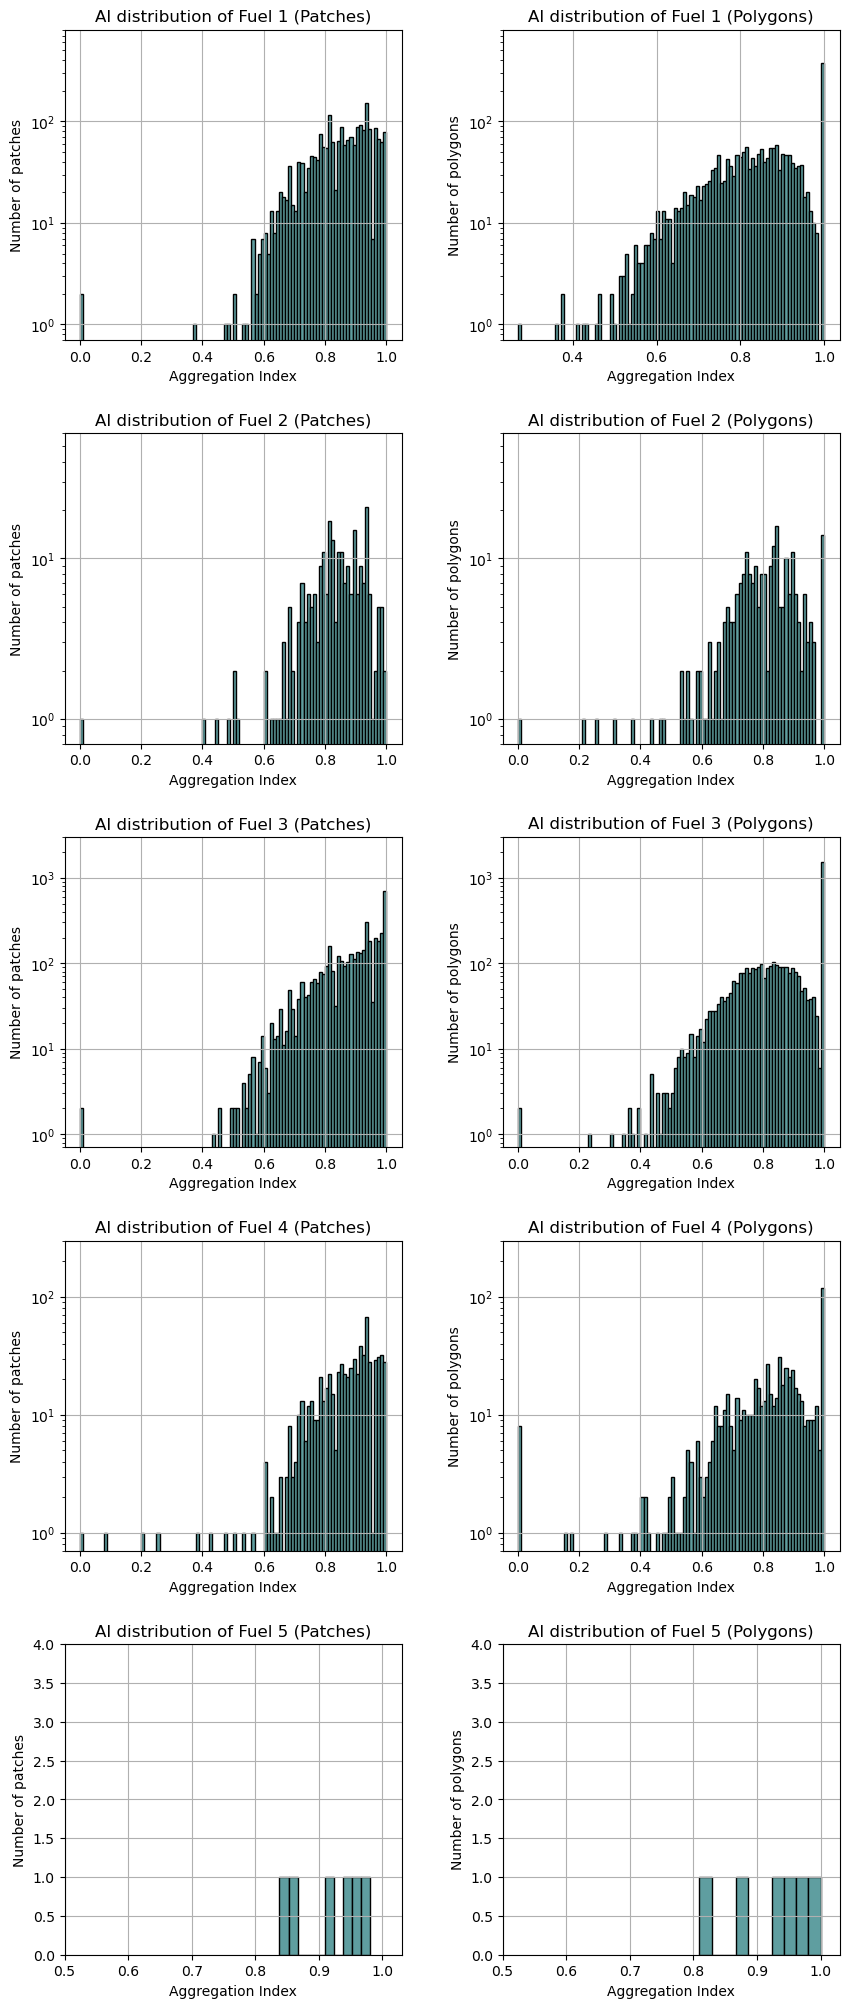

In [24]:
fig = plt.figure(figsize=(10,25))
fig.subplots_adjust(hspace = 0.3, wspace=0.3)

ax1 = fig.add_subplot(5, 2, 1)
ax2 = fig.add_subplot(5, 2, 2)
ax3 = fig.add_subplot(5, 2, 3)
ax4 = fig.add_subplot(5, 2, 4)
ax5 = fig.add_subplot(5, 2, 5)
ax6 = fig.add_subplot(5, 2, 6)
ax7 = fig.add_subplot(5, 2, 7)
ax8 = fig.add_subplot(5, 2, 8)
ax9 = fig.add_subplot(5, 2, 9)
ax10 = fig.add_subplot(5,2, 10)

ax1.hist(AI_patch_poly_Fuel1['AI (patch)'], bins=100, color="cadetblue", edgecolor= 'black')
ax2.hist(AI_patch_poly_Fuel1['AI'], bins= 100, color="cadetblue",edgecolor= 'black')
ax3.hist(AI_patch_poly_Fuel2['AI (patch)'], bins= 100 , color="cadetblue", edgecolor= 'black')
ax4.hist(AI_patch_poly_Fuel2['AI'], bins= 100, color="cadetblue", edgecolor= 'black')
ax5.hist(AI_patch_poly_Fuel3['AI (patch)'], bins= 100 , color="cadetblue", edgecolor= 'black')
ax6.hist(AI_patch_poly_Fuel3['AI'], bins= 100, color="cadetblue", edgecolor= 'black')
ax7.hist(AI_patch_poly_Fuel4['AI (patch)'], bins= 100, color="cadetblue", edgecolor= 'black')
ax8.hist(AI_patch_poly_Fuel4['AI'], bins= 100, color="cadetblue", edgecolor= 'black')
ax9.hist(AI_patch_poly_Fuel5['AI (patch)'], bins= 10, color="cadetblue", edgecolor= 'black')
ax10.hist(AI_patch_poly_Fuel5['AI'], bins= 10, color="cadetblue", edgecolor= 'black')


ax1.set_ylim(7*10**(-1), 8*10**2)
ax2.set_ylim(7*10**(-1), 8*10**2)
ax3.set_ylim(7*10**(-1), 6*10**1)
ax4.set_ylim(7*10**(-1), 6*10**1)
ax5.set_ylim(7*10**(-1), 3*10**3)
ax6.set_ylim(7*10**(-1), 3*10**3)
ax7.set_ylim(7*10**(-1), 3*10**2)
ax8.set_ylim(7*10**(-1), 3*10**2)
ax9.set_ylim(0,4)
ax9.set_xlim(0.5,1.03)
ax10.set_ylim(0,4)
ax10.set_xlim(0.5,1.03)


ax1.set_xlabel('Aggregation Index')
ax2.set_xlabel('Aggregation Index')
ax3.set_xlabel('Aggregation Index')
ax4.set_xlabel('Aggregation Index')
ax5.set_xlabel('Aggregation Index')
ax6.set_xlabel('Aggregation Index')
ax7.set_xlabel('Aggregation Index')
ax8.set_xlabel('Aggregation Index')
ax9.set_xlabel('Aggregation Index')
ax10.set_xlabel('Aggregation Index')


ax1.set_ylabel('Number of patches')
ax2.set_ylabel('Number of polygons')
ax3.set_ylabel('Number of patches')
ax4.set_ylabel('Number of polygons')
ax5.set_ylabel('Number of patches')
ax6.set_ylabel('Number of polygons')
ax7.set_ylabel('Number of patches')
ax8.set_ylabel('Number of polygons')
ax9.set_ylabel('Number of patches')
ax10.set_ylabel('Number of polygons')


ax1.set_title('AI distribution of Fuel 1 (Patches)')
ax2.set_title('AI distribution of Fuel 1 (Polygons)')
ax3.set_title('AI distribution of Fuel 2 (Patches)')
ax4.set_title('AI distribution of Fuel 2 (Polygons)')
ax5.set_title('AI distribution of Fuel 3 (Patches)')
ax6.set_title('AI distribution of Fuel 3 (Polygons)')
ax7.set_title('AI distribution of Fuel 4 (Patches)')
ax8.set_title('AI distribution of Fuel 4 (Polygons)')
ax9.set_title('AI distribution of Fuel 5 (Patches)')
ax10.set_title('AI distribution of Fuel 5 (Polygons)')


ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()
ax7.grid()
ax8.grid()
ax9.grid()
ax10.grid()

ax1.set_yscale('Log')
ax2.set_yscale('Log')
ax3.set_yscale('Log')
ax4.set_yscale('Log')
ax5.set_yscale('Log')
ax6.set_yscale('Log')
ax7.set_yscale('Log')
ax8.set_yscale('Log')



#plt.show()

#plt.savefig("/home/coca/Maps_TFM/Raster/Output/Fuel1/AI_Dist_Fuel1.jpg")

/tmp/ipykernel_19507/3762169385.py:87: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  ax1.set_yscale('Log')
/tmp/ipykernel_19507/3762169385.py:88: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  ax2.set_yscale('Log')
/tmp/ipykernel_19507/3762169385.py:89: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  ax3.set_yscale('Log')
/tmp/ipykernel_19507/3762169385.py:90: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  ax4.set_yscale('Log')
/tmp/ipykernel_19507/3762169385.py:91: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor relea

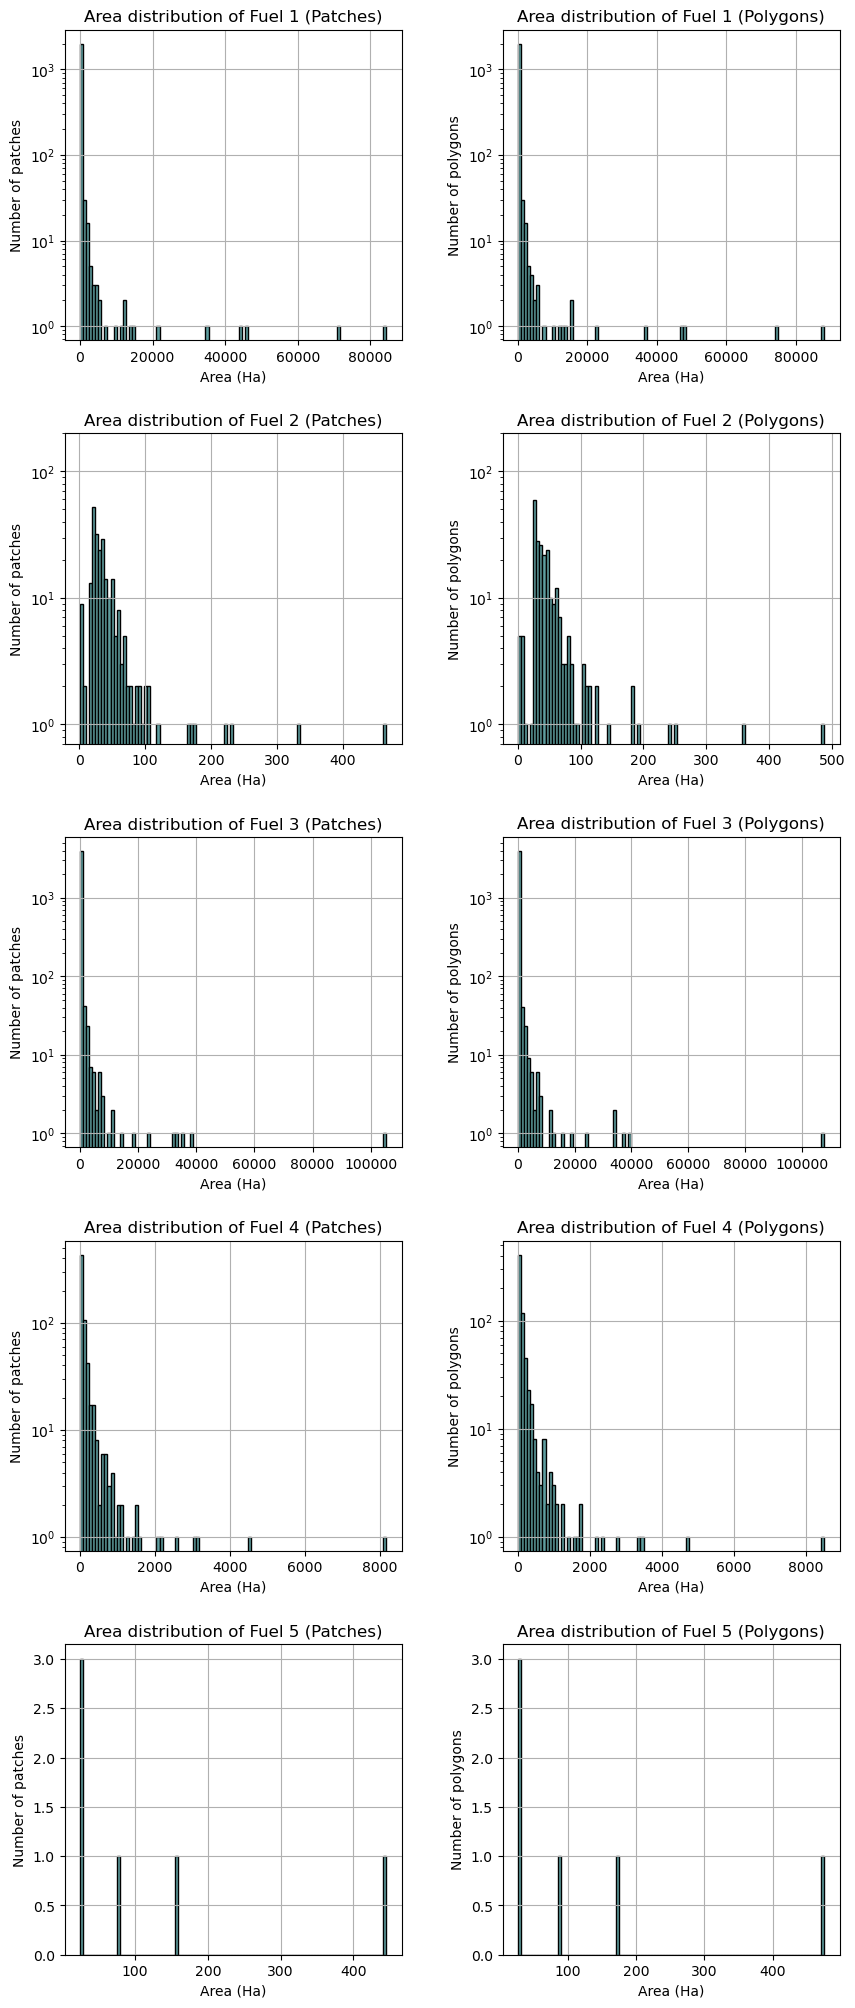

In [25]:
fig = plt.figure(figsize=(10,25))
fig.subplots_adjust(hspace = 0.3, wspace=0.3)

ax1 = fig.add_subplot(5, 2, 1)
ax2 = fig.add_subplot(5, 2, 2)
ax3 = fig.add_subplot(5, 2, 3)
ax4 = fig.add_subplot(5, 2, 4)
ax5 = fig.add_subplot(5, 2, 5)
ax6 = fig.add_subplot(5, 2, 6)
ax7 = fig.add_subplot(5, 2, 7)
ax8 = fig.add_subplot(5, 2, 8)
ax9 = fig.add_subplot(5, 2, 9)
ax10 = fig.add_subplot(5,2, 10)


ax1.hist(AI_patch_poly_Fuel1['Area_Ha (patch)'], bins= 100, color="cadetblue", edgecolor= 'black')
ax2.hist(AI_patch_poly_Fuel1['Area_Ha'], bins= 100, color="cadetblue",edgecolor= 'black')
ax3.hist(AI_patch_poly_Fuel2['Area_Ha (patch)'], bins= 100 , color="cadetblue", edgecolor= 'black')
ax4.hist(AI_patch_poly_Fuel2['Area_Ha'], bins= 100, color="cadetblue", edgecolor= 'black')
ax5.hist(AI_patch_poly_Fuel3['Area_Ha (patch)'], bins= 100  , color="cadetblue", edgecolor= 'black')
ax6.hist(AI_patch_poly_Fuel3['Area_Ha'], bins= 100, color="cadetblue", edgecolor= 'black')
ax7.hist(AI_patch_poly_Fuel4['Area_Ha (patch)'], bins= 100, color="cadetblue", edgecolor= 'black')
ax8.hist(AI_patch_poly_Fuel4['Area_Ha'], bins= 100, color="cadetblue", edgecolor= 'black')
ax9.hist(AI_patch_poly_Fuel5['Area_Ha (patch)'], bins= 100, color="cadetblue", edgecolor= 'black')
ax10.hist(AI_patch_poly_Fuel5['Area_Ha'], bins= 100, color="cadetblue", edgecolor= 'black')


#ax1.set_ylim(7*10**(-1), 5*10**2)
#ax2.set_xlim(0, 250000)
ax3.set_ylim(7*10**(-1), 2*10**2)
ax4.set_ylim(7*10**(-1), 2*10**2)
#ax5.set_ylim(7*10**(-1), 2*10**3)
#ax6.set_ylim(7*10**(-1), 2*10**3)
#ax7.set_ylim(7*10**(-1), 2*10**2)
#ax8.set_ylim(7*10**(-1), 2*10**2)
#ax9.set_xlim(0,500)
#ax10.set_xlim(0,500)


ax1.set_xlabel('Area (Ha)')
ax2.set_xlabel('Area (Ha)')
ax3.set_xlabel('Area (Ha)')
ax4.set_xlabel('Area (Ha)')
ax5.set_xlabel('Area (Ha)')
ax6.set_xlabel('Area (Ha)')
ax7.set_xlabel('Area (Ha)')
ax8.set_xlabel('Area (Ha)')
ax9.set_xlabel('Area (Ha)')
ax10.set_xlabel('Area (Ha)')


ax1.set_ylabel('Number of patches')
ax2.set_ylabel('Number of polygons')
ax3.set_ylabel('Number of patches')
ax4.set_ylabel('Number of polygons')
ax5.set_ylabel('Number of patches')
ax6.set_ylabel('Number of polygons')
ax7.set_ylabel('Number of patches')
ax8.set_ylabel('Number of polygons')
ax9.set_ylabel('Number of patches')
ax10.set_ylabel('Number of polygons')


ax1.set_title('Area distribution of Fuel 1 (Patches)')
ax2.set_title('Area distribution of Fuel 1 (Polygons)')
ax3.set_title('Area distribution of Fuel 2 (Patches)')
ax4.set_title('Area distribution of Fuel 2 (Polygons)')
ax5.set_title('Area distribution of Fuel 3 (Patches)')
ax6.set_title('Area distribution of Fuel 3 (Polygons)')
ax7.set_title('Area distribution of Fuel 4 (Patches)')
ax8.set_title('Area distribution of Fuel 4 (Polygons)')
ax9.set_title('Area distribution of Fuel 5 (Patches)')
ax10.set_title('Area distribution of Fuel 5 (Polygons)')


ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()
ax7.grid()
ax8.grid()
ax9.grid()
ax10.grid()

ax1.set_yscale('Log')
ax2.set_yscale('Log')
ax3.set_yscale('Log')
ax4.set_yscale('Log')
ax5.set_yscale('Log')
ax6.set_yscale('Log')
ax7.set_yscale('Log')
ax8.set_yscale('Log')
#ax9.set_xscale('Log')
#ax10.set_xscale('Log')



#plt.show()

#plt.savefig("/home/coca/Maps_TFM/Raster/Output/Fuel1/AI_Dist_Fuel1.jpg")

/tmp/ipykernel_19507/218987147.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5,2,1)
/tmp/ipykernel_19507/1045485680.py:10: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,10**3)
/tmp/ipykernel_19507/218987147.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5,2,2)
/tmp/ipykernel_19507/1045485680.py:23: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,10**3)


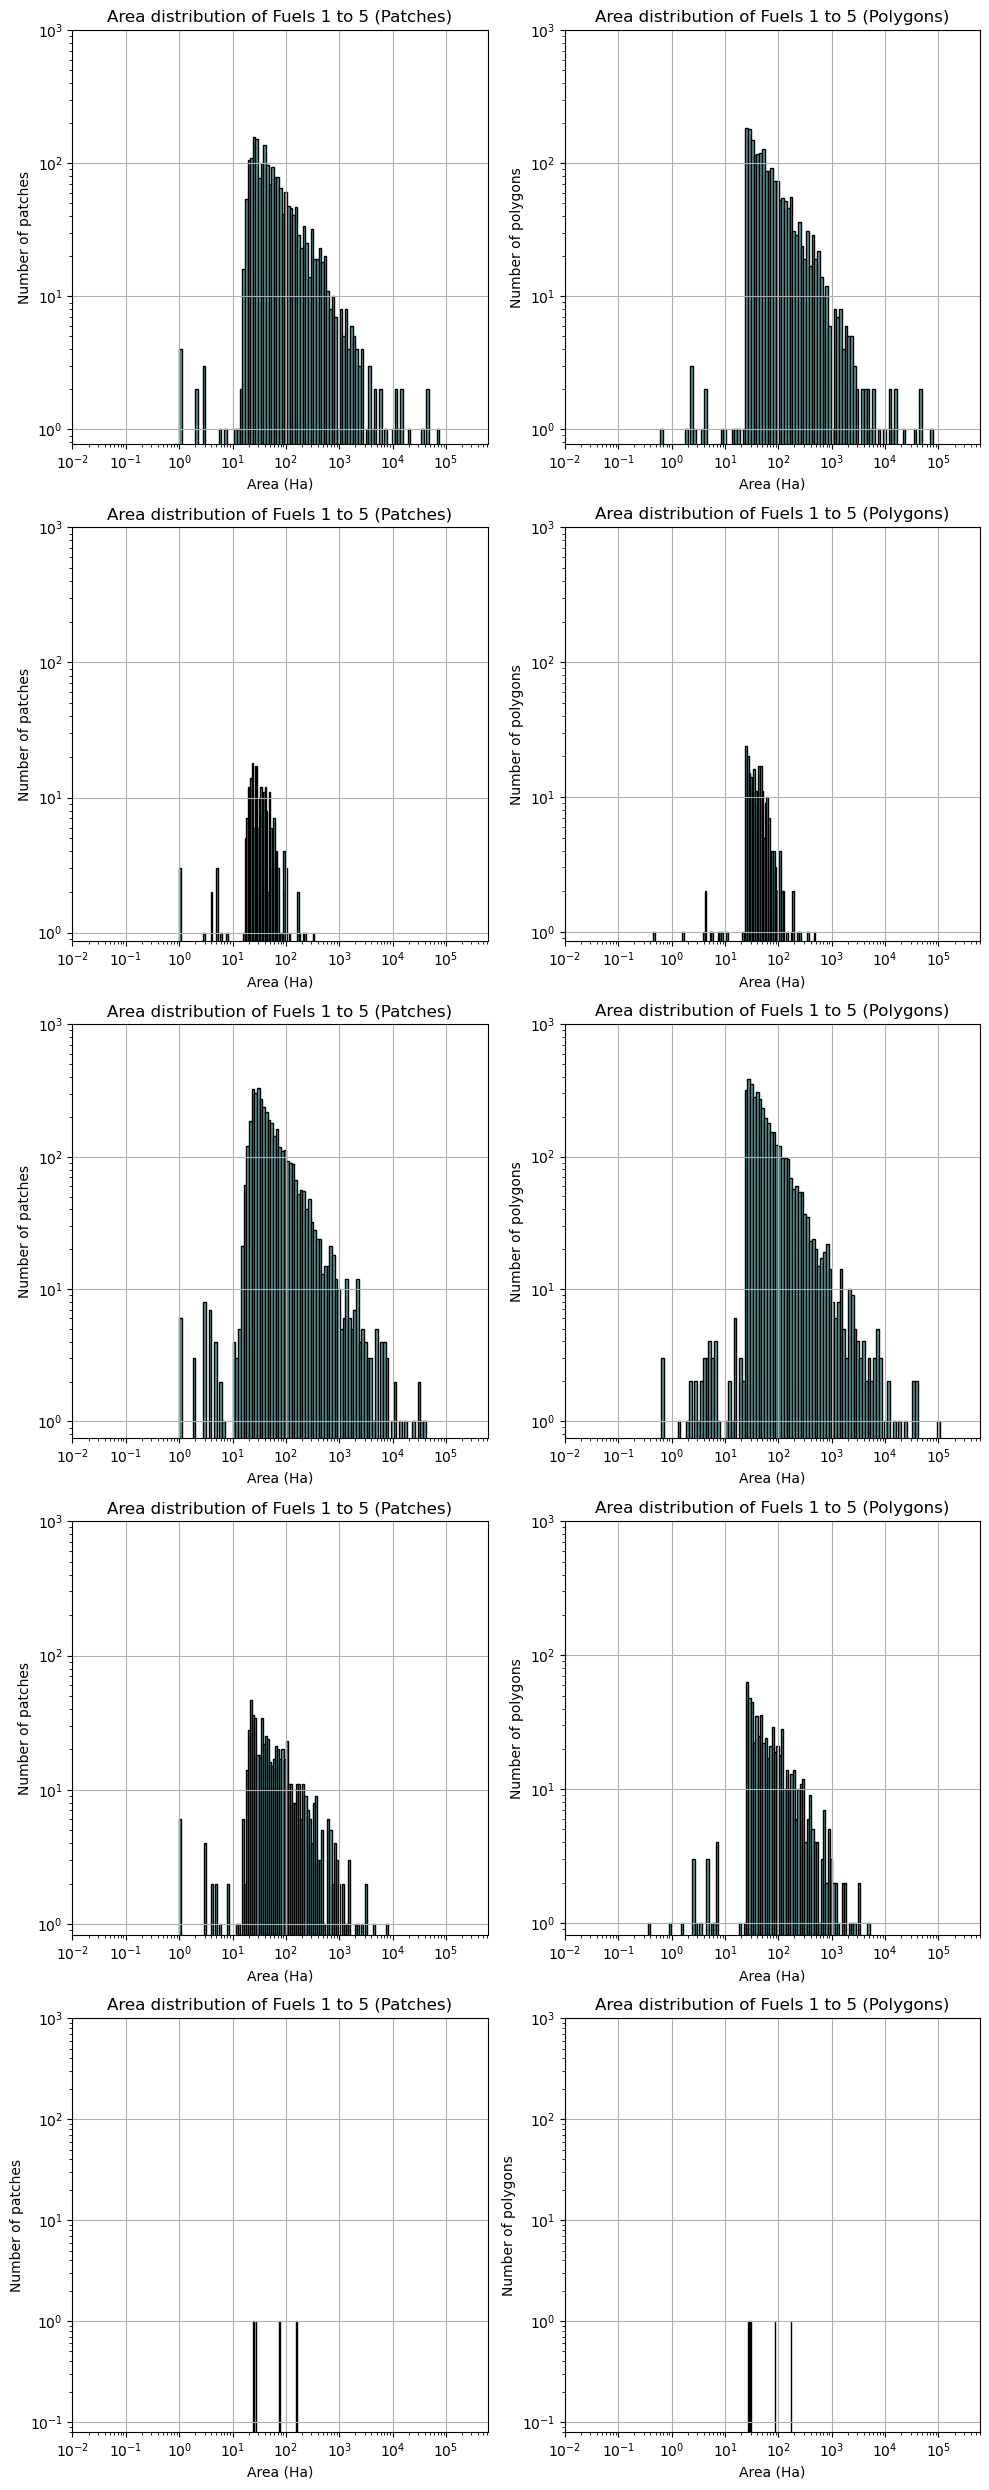

In [26]:
# Number of patches Vs. Area // Number of polygons Vs. Area
# Using lognormal distribution in the X axis 

fig, ax = plt.subplots(nrows = 1, ncols= 2, figsize=(10,25))

# Vegetation type 1
plt.subplot(5,2,1)
patch_loghist(AI_patch_poly_Fuel1['Area_Ha (patch)'], 100)

plt.subplot(5,2,2)
poly_loghist(AI_patch_poly_Fuel1['Area_Ha'], 100)

# Vegetation type 2
plt.subplot(5,2,3)
patch_loghist(AI_patch_poly_Fuel2['Area_Ha (patch)'], 100)

plt.subplot(5,2,4)
poly_loghist(AI_patch_poly_Fuel2['Area_Ha'], 100)

# Vegetation type 3
plt.subplot(5,2,5)
patch_loghist(AI_patch_poly_Fuel3['Area_Ha (patch)'], 100)

plt.subplot(5,2,6)
poly_loghist(AI_patch_poly_Fuel3['Area_Ha'], 100)

# Vegetation type 4
plt.subplot(5,2,7)
patch_loghist(AI_patch_poly_Fuel4['Area_Ha (patch)'], 100)

plt.subplot(5,2,8)
poly_loghist(AI_patch_poly_Fuel4['Area_Ha'], 100)

# Vegetation type 5
plt.subplot(5,2,9)
patch_loghist(AI_patch_poly_Fuel5['Area_Ha (patch)'], 100)

plt.subplot(5,2,10)
poly_loghist(AI_patch_poly_Fuel5['Area_Ha'], 100)

plt.tight_layout()
plt.show()

#plt.savefig("/home/coca/Maps_TFM/Raster/Output/Fuel1/AI_Dist_Fuel1.jpg")

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

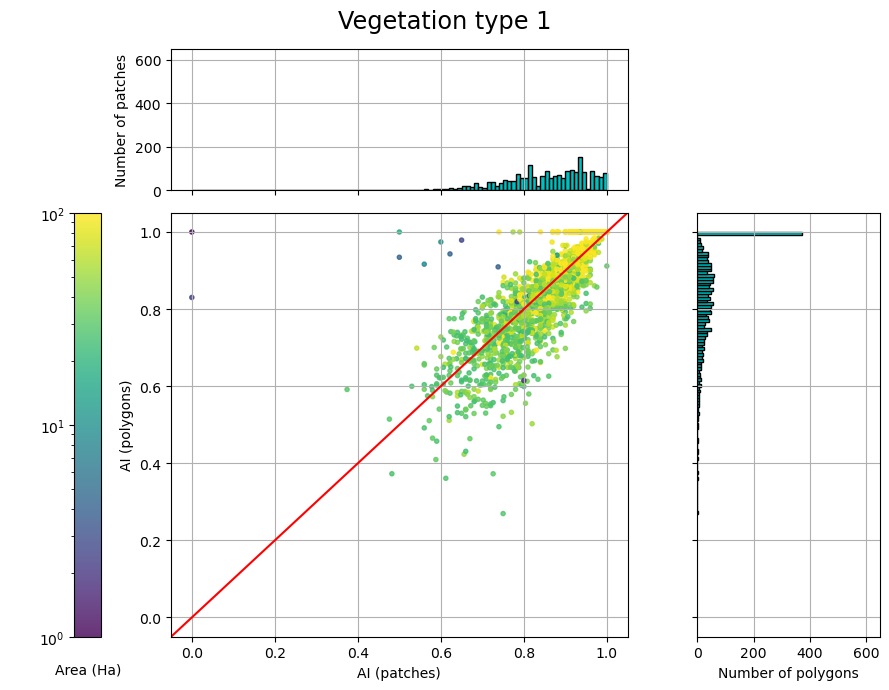

In [28]:
#Set the data for Fuel 1
x = AI_patch_poly_Fuel1['AI (patch)']
y = AI_patch_poly_Fuel1['AI']
z = AI_patch_poly_Fuel1['Area_Ha']

def scatter_hist_and_colorbar(x, y, z, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
  
    # the scatter plot:
    sc = ax.scatter(x, y, c = z, norm = colors.LogNorm(1, 100), marker='.', alpha=0.8)
    # now determine nice limits by hand:
    #binwidth = 0.1
    #xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    #lim = (int(xymax/binwidth)) * binwidth

    #bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=100, color = 'c', edgecolor = 'black')
    ax_histy.hist(y, bins=100, orientation='horizontal', color = 'c', edgecolor = 'black')
    
    return sc
     
    
    
    # Start with a square Figure.
fig = plt.figure(figsize=(9, 7))

fig.suptitle('Vegetation type 1', fontsize = 'xx-large', va = 'top')
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(ncols=3, nrows=2,  width_ratios=[1,5,2], height_ratios=[1,3],
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

# Create the Axes.
ax0 = fig.add_subplot(gs[1, 0])

ax = fig.add_subplot(gs[1, 1])
ax.set_xlabel ('AI (patches)')
ax.set_ylabel ('AI (polygons)')
ax.axline([0,0], slope =1, color = 'red')
plt.grid()

ax_histx = fig.add_subplot(gs[0, 1], sharex=ax)
ax_histx.set_ylim(0, 650)
ax_histx.set_ylabel('Number of patches')
plt.grid()

ax_histy = fig.add_subplot(gs[1, 2], sharey=ax)
ax_histy.set_xlim(0,650)
ax_histy.set_xlabel('Number of polygons')
plt.grid()
# Draw the scatter plot and marginals.
sc1 = scatter_hist_and_colorbar(x, y,z, ax, ax_histx, ax_histy)

divider = make_axes_locatable(ax)


divider = make_axes_locatable(ax0)
ca = divider.append_axes('right', size='50%')
ax0.axis('off')


cbar=fig.colorbar(sc1, cax=ca, orientation='vertical', alpha=False)
cbar.ax.set_xlabel('Area (Ha)',rotation=0,labelpad=15, loc = 'center')

cbar.ax.yaxis.set_ticks_position("left")

gs.tight_layout(fig, w_pad=1, h_pad=1.0)

#plt.savefig('example.png')
plt.show()

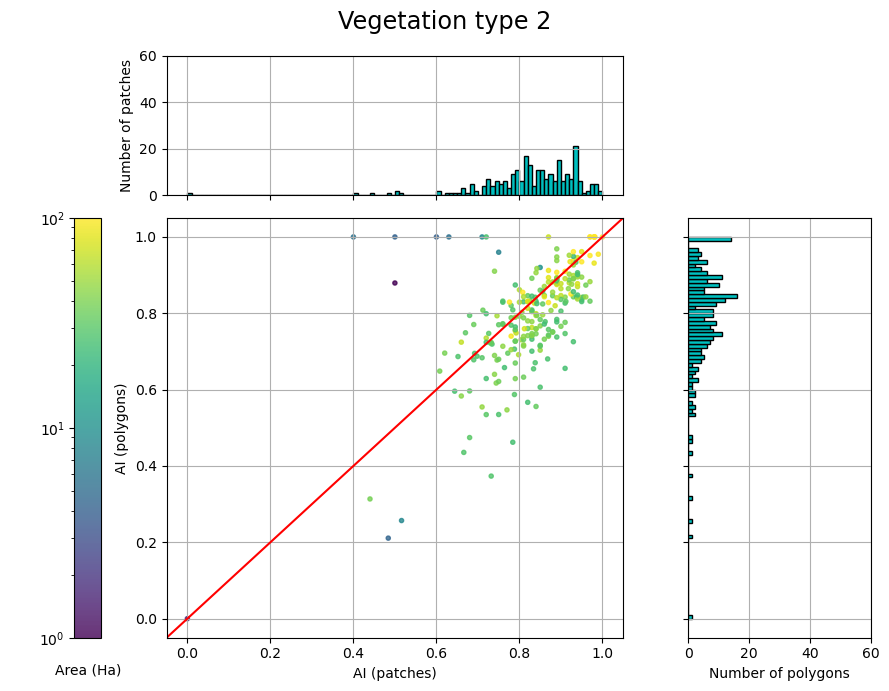

In [29]:
#Set the data for Fuel 2
x = AI_patch_poly_Fuel2['AI (patch)']
y = AI_patch_poly_Fuel2['AI']
z = AI_patch_poly_Fuel2['Area_Ha']

def scatter_hist_and_colorbar(x, y, z, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
  
    # the scatter plot:
    sc = ax.scatter(x, y, c = z, norm = colors.LogNorm(1, 100), marker='.', alpha=0.8)
    # now determine nice limits by hand:
    #binwidth = 0.1
    #xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    #lim = (int(xymax/binwidth)) * binwidth

    #bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=100, color = 'c', edgecolor = 'black')
    ax_histy.hist(y, bins=100, orientation='horizontal', color = 'c', edgecolor = 'black')
    
    return sc
     
    
    
    # Start with a square Figure.
fig = plt.figure(figsize=(9, 7))

fig.suptitle('Vegetation type 2', fontsize = 'xx-large', va = 'top')
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(ncols=3, nrows=2,  width_ratios=[1,5,2], height_ratios=[1,3],
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

# Create the Axes.
ax0 = fig.add_subplot(gs[1, 0])

ax = fig.add_subplot(gs[1, 1])
ax.set_xlabel ('AI (patches)')
ax.set_ylabel ('AI (polygons)')
ax.axline([0,0], slope =1, color = 'red')
plt.grid()

ax_histx = fig.add_subplot(gs[0, 1], sharex=ax)
ax_histx.set_ylim(0, 60)
ax_histx.set_ylabel('Number of patches')
plt.grid()

ax_histy = fig.add_subplot(gs[1, 2], sharey=ax)
ax_histy.set_xlim(0,60)
ax_histy.set_xlabel('Number of polygons')
plt.grid()
# Draw the scatter plot and marginals.
sc1 = scatter_hist_and_colorbar(x, y,z, ax, ax_histx, ax_histy)

divider = make_axes_locatable(ax)


divider = make_axes_locatable(ax0)
ca = divider.append_axes('right', size='50%')
ax0.axis('off')


cbar=fig.colorbar(sc1, cax=ca, orientation='vertical', alpha=False)
cbar.ax.set_xlabel('Area (Ha)',rotation=0,labelpad=15, loc = 'center')
cbar.ax.yaxis.set_ticks_position("left")

gs.tight_layout(fig, w_pad=1, h_pad=1.0)

#plt.savefig('example.png')
plt.show()

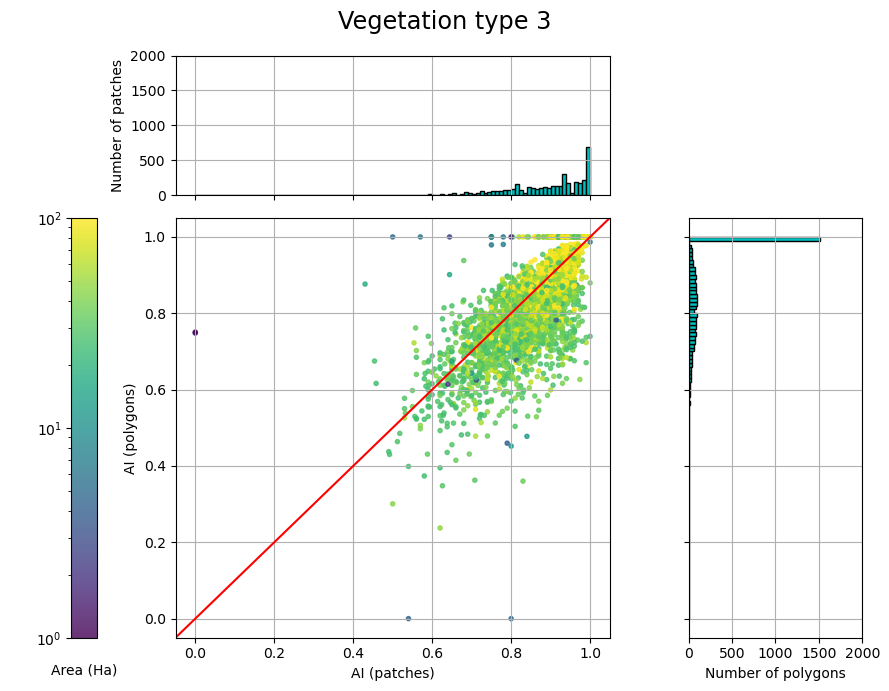

In [30]:
#Set the data for Fuel 3
x = AI_patch_poly_Fuel3['AI (patch)']
y = AI_patch_poly_Fuel3['AI']
z = AI_patch_poly_Fuel3['Area_Ha']

def scatter_hist_and_colorbar(x, y, z, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
  
    # the scatter plot:
    sc = ax.scatter(x, y, c = z, norm = colors.LogNorm(1, 100), marker='.', alpha=0.8)
    # now determine nice limits by hand:
    #binwidth = 0.1
    #xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    #lim = (int(xymax/binwidth)) * binwidth

    #bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=100, color = 'c', edgecolor = 'black')
    ax_histy.hist(y, bins=100, orientation='horizontal', color = 'c', edgecolor = 'black')
    
    return sc
     
    
    
    # Start with a square Figure.
fig = plt.figure(figsize=(9, 7))

fig.suptitle('Vegetation type 3', fontsize = 'xx-large', va = 'top')
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(ncols=3, nrows=2,  width_ratios=[1,5,2], height_ratios=[1,3],
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

# Create the Axes.
ax0 = fig.add_subplot(gs[1, 0])

ax = fig.add_subplot(gs[1, 1])
ax.set_xlabel ('AI (patches)')
ax.set_ylabel ('AI (polygons)')
ax.axline([0,0], slope =1, color = 'red')
plt.grid()

ax_histx = fig.add_subplot(gs[0, 1], sharex=ax)
ax_histx.set_ylim(0, 2000)
ax_histx.set_ylabel('Number of patches')
plt.grid()

ax_histy = fig.add_subplot(gs[1, 2], sharey=ax)
ax_histy.set_xlim(0,2000)
ax_histy.set_xlabel('Number of polygons')
plt.grid()
# Draw the scatter plot and marginals.
sc1 = scatter_hist_and_colorbar(x, y,z, ax, ax_histx, ax_histy)

divider = make_axes_locatable(ax)


divider = make_axes_locatable(ax0)
ca = divider.append_axes('right', size='50%')
ax0.axis('off')


cbar=fig.colorbar(sc1, cax=ca, orientation='vertical', alpha=False)
cbar.ax.set_xlabel('Area (Ha)',rotation=0,labelpad=15, loc = 'center')

cbar.ax.yaxis.set_ticks_position("left")

gs.tight_layout(fig, w_pad=1, h_pad=1.0)

#plt.savefig('example.png')
plt.show()

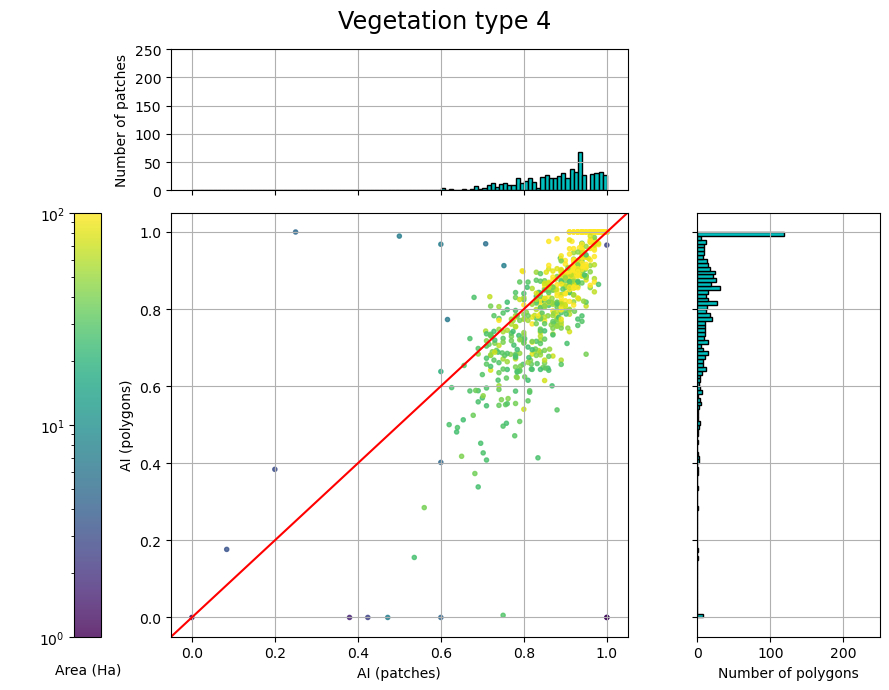

In [31]:
#Set the data for Fuel 4
x = AI_patch_poly_Fuel4['AI (patch)']
y = AI_patch_poly_Fuel4['AI']
z = AI_patch_poly_Fuel4['Area_Ha']

def scatter_hist_and_colorbar(x, y, z, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
  
    # the scatter plot:
    sc = ax.scatter(x, y, c = z, norm = colors.LogNorm(1, 100), marker='.', alpha=0.8)
    # now determine nice limits by hand:
    #binwidth = 0.1
    #xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    #lim = (int(xymax/binwidth)) * binwidth

    #bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=100, color = 'c', edgecolor = 'black')
    ax_histy.hist(y, bins=100, orientation='horizontal', color = 'c', edgecolor = 'black')
    
    return sc
     
    
    
    # Start with a square Figure.
fig = plt.figure(figsize=(9, 7))

fig.suptitle('Vegetation type 4', fontsize = 'xx-large', va = 'top')
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(ncols=3, nrows=2,  width_ratios=[1,5,2], height_ratios=[1,3],
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

# Create the Axes.
ax0 = fig.add_subplot(gs[1, 0])

ax = fig.add_subplot(gs[1, 1])
ax.set_xlabel ('AI (patches)')
ax.set_ylabel ('AI (polygons)')
ax.axline([0,0], slope =1, color = 'red')
plt.grid()

ax_histx = fig.add_subplot(gs[0, 1], sharex=ax)
ax_histx.set_ylim(0, 250)
ax_histx.set_ylabel('Number of patches')
plt.grid()

ax_histy = fig.add_subplot(gs[1, 2], sharey=ax)
ax_histy.set_xlim(0,250)
ax_histy.set_xlabel('Number of polygons')
plt.grid()
# Draw the scatter plot and marginals.
sc1 = scatter_hist_and_colorbar(x, y,z, ax, ax_histx, ax_histy)

divider = make_axes_locatable(ax)


divider = make_axes_locatable(ax0)
ca = divider.append_axes('right', size='50%')
ax0.axis('off')


cbar=fig.colorbar(sc1, cax=ca, orientation='vertical', alpha=False)
cbar.ax.set_xlabel('Area (Ha)',rotation=0,labelpad=15, loc = 'center')

cbar.ax.yaxis.set_ticks_position("left")

gs.tight_layout(fig, w_pad=1, h_pad=1.0)

#plt.savefig('example.png')
plt.show()

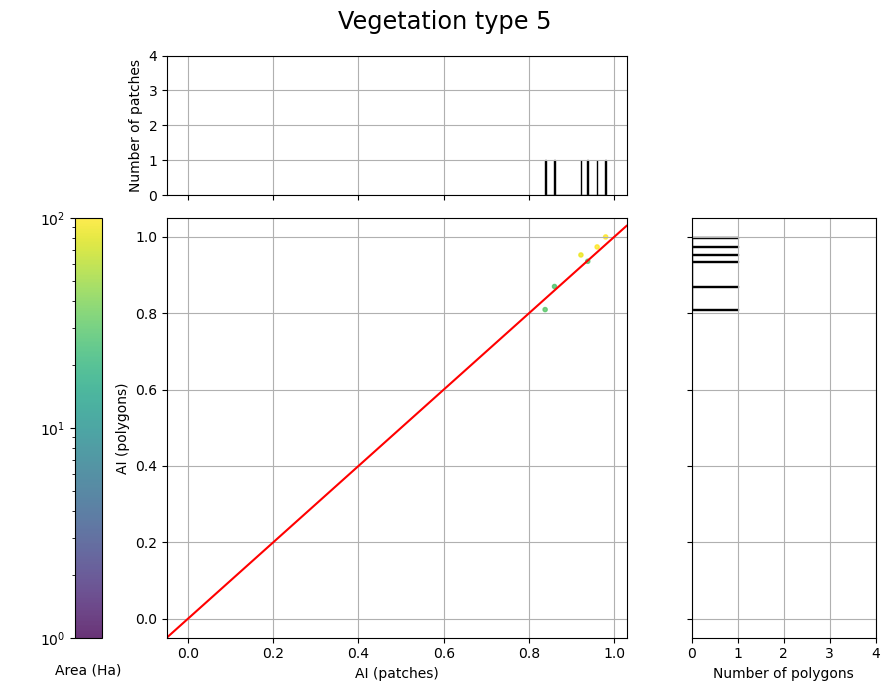

In [32]:
#Set the data for Fuel 5
x = AI_patch_poly_Fuel5['AI (patch)']
y = AI_patch_poly_Fuel5['AI']
z = AI_patch_poly_Fuel5['Area_Ha']

def scatter_hist_and_colorbar(x, y, z, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
  
    # the scatter plot:
    sc = ax.scatter(x, y, c = z, norm = colors.LogNorm(1, 100), marker='.', alpha=0.8)
    # now determine nice limits by hand:
    #binwidth = 0.1
    #xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    #lim = (int(xymax/binwidth)) * binwidth

    #bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=100, color = 'c', edgecolor = 'black')
    ax_histy.hist(y, bins=100, orientation='horizontal', color = 'c', edgecolor = 'black')
    
    return sc
     
    
    
    # Start with a square Figure.
fig = plt.figure(figsize=(9, 7))

fig.suptitle('Vegetation type 5', fontsize = 'xx-large', va = 'top')
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(ncols=3, nrows=2,  width_ratios=[1,5,2], height_ratios=[1,3],
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

# Create the Axes.
ax0 = fig.add_subplot(gs[1, 0])

ax = fig.add_subplot(gs[1, 1])
ax.set_xlabel ('AI (patches)')
ax.set_ylabel ('AI (polygons)')
ax.axline([0,0], slope =1, color = 'red')
plt.grid()

ax_histx = fig.add_subplot(gs[0, 1], sharex=ax)
ax_histx.set_ylim(0, 4)
ax_histx.set_ylabel('Number of patches')
plt.grid()

ax_histy = fig.add_subplot(gs[1, 2], sharey=ax)
ax_histy.set_xlim(0,4)
ax_histy.set_xlabel('Number of polygons')
plt.grid()
# Draw the scatter plot and marginals.
sc1 = scatter_hist_and_colorbar(x, y,z, ax, ax_histx, ax_histy)

divider = make_axes_locatable(ax)


divider = make_axes_locatable(ax0)
ca = divider.append_axes('right', size='50%')
ax0.axis('off')


cbar=fig.colorbar(sc1, cax=ca, orientation='vertical', alpha=False)
cbar.ax.set_xlabel('Area (Ha)',rotation=0,labelpad=15, loc = 'center')

cbar.ax.yaxis.set_ticks_position("left")

gs.tight_layout(fig, w_pad=1, h_pad=1.0)

#plt.savefig('example.png')
plt.show()

/tmp/ipykernel_19507/3382641467.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt. subplot(5,2,1)


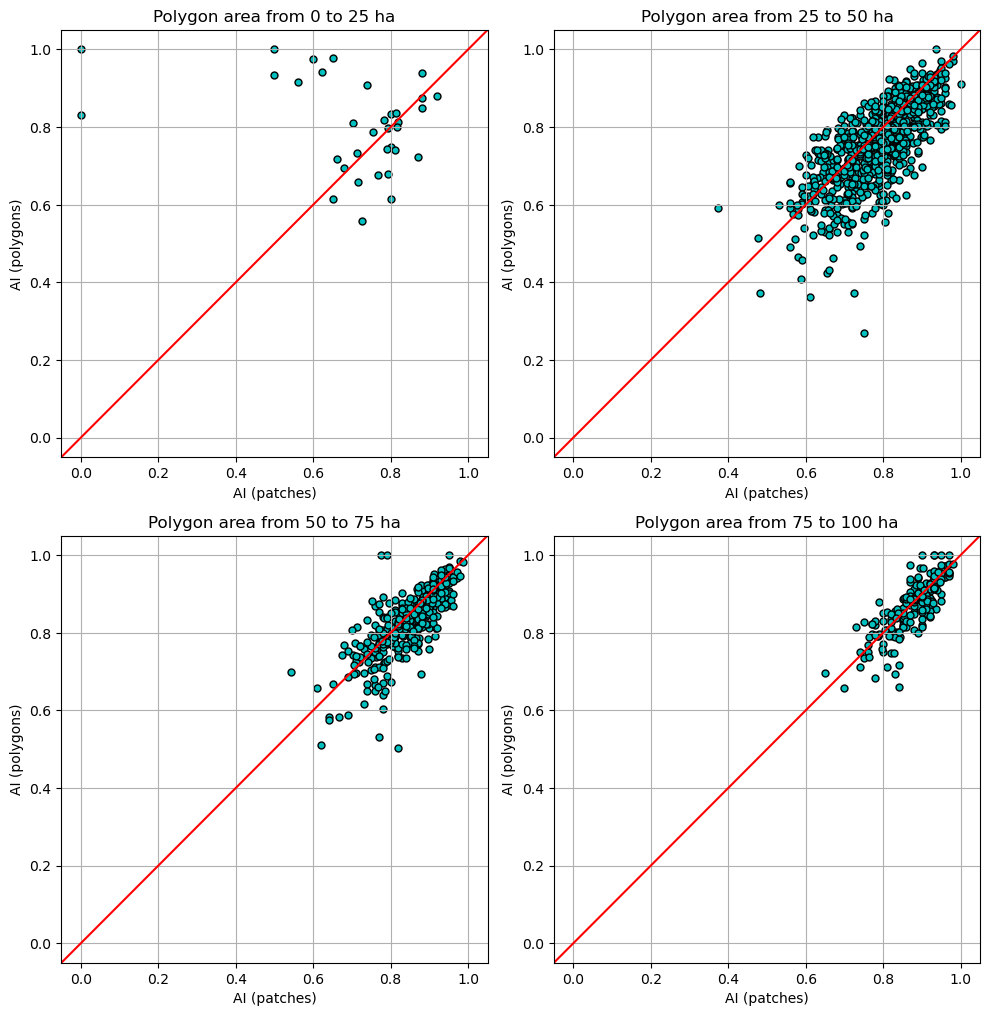

In [33]:
# Here, the study of the correlation for different class of polygon size is performed
# the data used for that purpose is Fuel Category 1
# Plot the AI of patches vs the AI of polygons

import matplotlib.lines as mlines

plt.subplots(figsize = (10,25))

# Range tested: 0 to 25 ha
Fuel1_Range1 = AI_patch_poly_Fuel1.loc[(0<AI_patch_poly_Fuel1['Area_Ha']) & (AI_patch_poly_Fuel1['Area_Ha']<=25) ]

plt. subplot(5,2,1)
x1 = Fuel1_Range1['AI (patch)']
y1 = Fuel1_Range1['AI']
plt.scatter(x1, y1, color = 'c', edgecolor = 'black', marker='.', s= 100)
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.axline([0,0], slope =1, color ='red')
plt.title('Polygon area from 0 to 25 ha')
plt.xlabel('AI (patches)')
plt.ylabel('AI (polygons)')
plt.grid()

# Range tested: 25 to 50 ha
Fuel1_Range2 = AI_patch_poly_Fuel1.loc[(25<AI_patch_poly_Fuel1['Area_Ha']) & (AI_patch_poly_Fuel1['Area_Ha']<=50) ]

plt. subplot(5,2,2)
x2 = Fuel1_Range2['AI (patch)']
y2 = Fuel1_Range2['AI']
plt.scatter(x2, y2, color = 'c', edgecolor = 'black', marker='.', s = 100)
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.axline([0,0], slope =1, color = 'red')
plt.title('Polygon area from 25 to 50 ha')
plt.xlabel('AI (patches)')
plt.ylabel('AI (polygons)')
plt.grid()

# Range tested: 50 to 75 ha
Fuel1_Range3 = AI_patch_poly_Fuel1.loc[(50<AI_patch_poly_Fuel1['Area_Ha']) & (AI_patch_poly_Fuel1['Area_Ha']<=75) ]

plt. subplot(5,2,3)
x3 = Fuel1_Range3['AI (patch)']
y3 = Fuel1_Range3['AI']
plt.scatter(x3, y3, color = 'c', edgecolor = 'black', marker='.', s= 100)
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.axline([0,0], slope =1, color = 'red')
plt.title('Polygon area from 50 to 75 ha')
plt.xlabel('AI (patches)')
plt.ylabel('AI (polygons)')
plt.grid()

# Range tested: 75 to 100 ha
Fuel1_Range4 = AI_patch_poly_Fuel1.loc[(75<AI_patch_poly_Fuel1['Area_Ha']) & (AI_patch_poly_Fuel1['Area_Ha']<=100) ]

plt. subplot(5,2,4)
x4 = Fuel1_Range4['AI (patch)']
y4 = Fuel1_Range4['AI']
plt.scatter(x4, y4, color = 'c', edgecolor = 'black', marker='.', s=100)
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.axline([0,0], slope =1, color='red')
plt.title('Polygon area from 75 to 100 ha')
plt.xlabel('AI (patches)')
plt.ylabel('AI (polygons)')
plt.grid()


plt.tight_layout()

In [34]:
#Import the required library to compute the degree of correlation
from scipy import stats

In [35]:
# Here, the Pearson correlation coefficient and the p-Value area obtained for Fuel Category 1
print("Fuel1_Range1:", stats.pearsonr(x1,y1))
print("Fuel1_Range2:", stats.pearsonr(x2,y2))
print("Fuel1_Range3:", stats.pearsonr(x3,y3))
print("Fuel1_Range4:", stats.pearsonr(x4,y4))

Fuel1_Range1: PearsonRResult(statistic=-0.3317149342422504, pvalue=0.05529807614748898)
Fuel1_Range2: PearsonRResult(statistic=0.7485817411847335, pvalue=1.8374928969679563e-155)
Fuel1_Range3: PearsonRResult(statistic=0.7714793198498213, pvalue=5.8911665826499675e-68)
Fuel1_Range4: PearsonRResult(statistic=0.8142074667372755, pvalue=9.617422451649177e-47)


/tmp/ipykernel_19507/3508882035.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt. subplot(5,2,1)


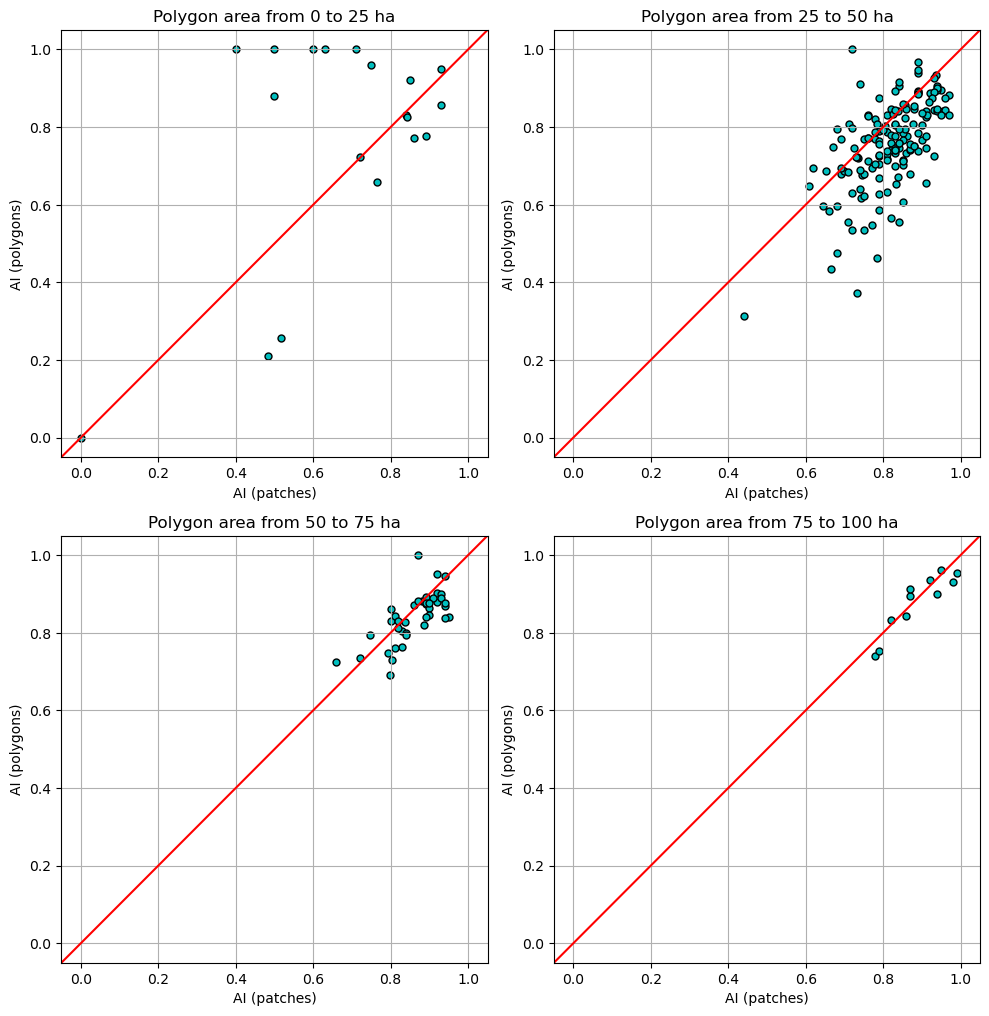

In [36]:
# Here, the study of the correlation for different class of polygon size is performed
# the data used for that purpose is Fuel Category 2
# Plot the AI of patches vs the AI of polygons

import matplotlib.lines as mlines

plt.subplots(figsize = (10,25))

# Range tested: 0 to 25 ha
Fuel2_Range1 = AI_patch_poly_Fuel2.loc[(0<AI_patch_poly_Fuel2['Area_Ha']) & (AI_patch_poly_Fuel2['Area_Ha']<=25) ]

plt. subplot(5,2,1)
x1 = Fuel2_Range1['AI (patch)']
y1 = Fuel2_Range1['AI']
plt.scatter(x1, y1, color = 'c', edgecolor = 'black', marker='.', s= 100)
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.axline([0,0], slope =1, color ='red')
plt.title('Polygon area from 0 to 25 ha')
plt.xlabel('AI (patches)')
plt.ylabel('AI (polygons)')
plt.grid()

# Range tested: 25 to 50 ha
Fuel2_Range2 = AI_patch_poly_Fuel2.loc[(25<AI_patch_poly_Fuel2['Area_Ha']) & (AI_patch_poly_Fuel2['Area_Ha']<=50) ]

plt. subplot(5,2,2)
x2 = Fuel2_Range2['AI (patch)']
y2 = Fuel2_Range2['AI']
plt.scatter(x2, y2, color = 'c', edgecolor = 'black', marker='.', s = 100)
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.axline([0,0], slope =1, color = 'red')
plt.title('Polygon area from 25 to 50 ha')
plt.xlabel('AI (patches)')
plt.ylabel('AI (polygons)')
plt.grid()

# Range tested: 50 to 75 ha
Fuel2_Range3 = AI_patch_poly_Fuel2.loc[(50<AI_patch_poly_Fuel2['Area_Ha']) & (AI_patch_poly_Fuel2['Area_Ha']<=75) ]

plt. subplot(5,2,3)
x3 = Fuel2_Range3['AI (patch)']
y3 = Fuel2_Range3['AI']
plt.scatter(x3, y3, color = 'c', edgecolor = 'black', marker='.', s= 100)
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.axline([0,0], slope =1, color = 'red')
plt.title('Polygon area from 50 to 75 ha')
plt.xlabel('AI (patches)')
plt.ylabel('AI (polygons)')
plt.grid()

# Range tested: 75 to 100 ha
Fuel2_Range4 = AI_patch_poly_Fuel2.loc[(75<AI_patch_poly_Fuel2['Area_Ha']) & (AI_patch_poly_Fuel2['Area_Ha']<=100) ]

plt. subplot(5,2,4)
x4 = Fuel2_Range4['AI (patch)']
y4 = Fuel2_Range4['AI']
plt.scatter(x4, y4, color = 'c', edgecolor = 'black', marker='.', s=100)
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.axline([0,0], slope =1, color='red')
plt.title('Polygon area from 75 to 100 ha')
plt.xlabel('AI (patches)')
plt.ylabel('AI (polygons)')
plt.grid()


plt.tight_layout()

In [37]:
# Here, the Pearson correlation coefficient and the p-Value area obtained for Fuel Category 2
print("Fuel2_Range1:", stats.pearsonr(x1,y1))
print("Fuel2_Range2:", stats.pearsonr(x2,y2))
print("Fuel2_Range3:", stats.pearsonr(x3,y3))
print("Fuel2_Range4:", stats.pearsonr(x4,y4))

Fuel2_Range1: PearsonRResult(statistic=0.5534044835385542, pvalue=0.013972710460394984)
Fuel2_Range2: PearsonRResult(statistic=0.6155185635057838, pvalue=1.5631279225014112e-17)
Fuel2_Range3: PearsonRResult(statistic=0.7181886118130649, pvalue=1.8148090936889613e-07)
Fuel2_Range4: PearsonRResult(statistic=0.9126545039401099, pvalue=8.867028885954726e-05)


/tmp/ipykernel_19507/22253532.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt. subplot(5,2,1)


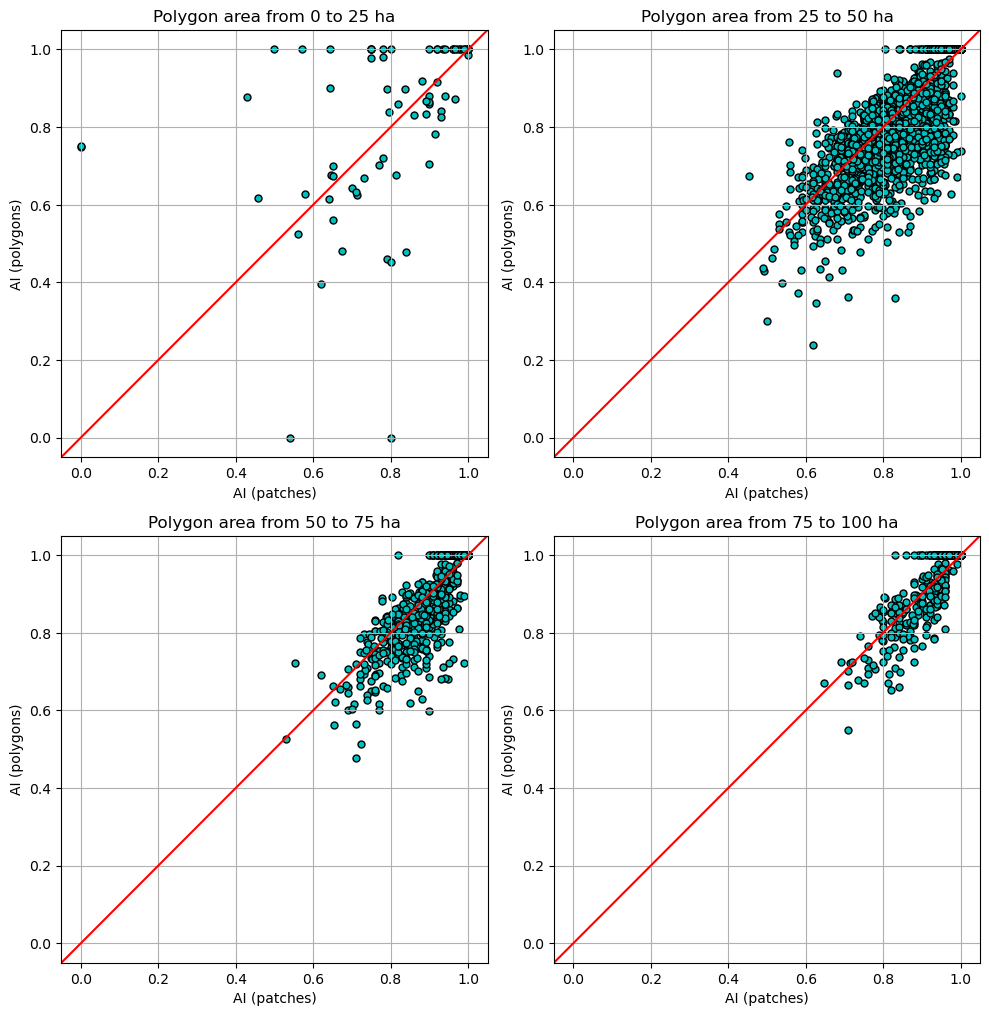

In [38]:
# Here, the study of the correlation for different class of polygon size is performed
# the data used for that purpose is Fuel Category 3
# Plot the AI of patches vs the AI of polygons

import matplotlib.lines as mlines

plt.subplots(figsize = (10,25))

# Range tested: 0 to 25 ha
Fuel3_Range1 = AI_patch_poly_Fuel3.loc[(0<AI_patch_poly_Fuel3['Area_Ha']) & (AI_patch_poly_Fuel3['Area_Ha']<=25) ]

plt. subplot(5,2,1)
x1 = Fuel3_Range1['AI (patch)']
y1 = Fuel3_Range1['AI']
plt.scatter(x1, y1, color = 'c', edgecolor = 'black', marker='.', s= 100)
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.axline([0,0], slope =1, color ='red')
plt.title('Polygon area from 0 to 25 ha')
plt.xlabel('AI (patches)')
plt.ylabel('AI (polygons)')
plt.grid()

# Range tested: 25 to 50 ha
Fuel3_Range2 = AI_patch_poly_Fuel3.loc[(25<AI_patch_poly_Fuel3['Area_Ha']) & (AI_patch_poly_Fuel3['Area_Ha']<=50) ]

plt. subplot(5,2,2)
x2 = Fuel3_Range2['AI (patch)']
y2 = Fuel3_Range2['AI']
plt.scatter(x2, y2, color = 'c', edgecolor = 'black', marker='.', s = 100)
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.axline([0,0], slope =1, color = 'red')
plt.title('Polygon area from 25 to 50 ha')
plt.xlabel('AI (patches)')
plt.ylabel('AI (polygons)')
plt.grid()

# Range tested: 50 to 75 ha
Fuel3_Range3 = AI_patch_poly_Fuel3.loc[(50<AI_patch_poly_Fuel3['Area_Ha']) & (AI_patch_poly_Fuel3['Area_Ha']<=75) ]

plt. subplot(5,2,3)
x3 = Fuel3_Range3['AI (patch)']
y3 = Fuel3_Range3['AI']
plt.scatter(x3, y3, color = 'c', edgecolor = 'black', marker='.', s= 100)
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.axline([0,0], slope =1, color = 'red')
plt.title('Polygon area from 50 to 75 ha')
plt.xlabel('AI (patches)')
plt.ylabel('AI (polygons)')
plt.grid()

# Range tested: 75 to 100 ha
Fuel3_Range4 = AI_patch_poly_Fuel3.loc[(75<AI_patch_poly_Fuel3['Area_Ha']) & (AI_patch_poly_Fuel3['Area_Ha']<=100) ]

plt. subplot(5,2,4)
x4 = Fuel3_Range4['AI (patch)']
y4 = Fuel3_Range4['AI']
plt.scatter(x4, y4, color = 'c', edgecolor = 'black', marker='.', s=100)
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.axline([0,0], slope =1, color='red')
plt.title('Polygon area from 75 to 100 ha')
plt.xlabel('AI (patches)')
plt.ylabel('AI (polygons)')
plt.grid()


plt.tight_layout()

In [39]:
# Here, the Pearson correlation coefficient and the p-Value area obtained for Fuel Category 3
print("Fuel3_Range1:", stats.pearsonr(x1,y1))
print("Fuel3_Range2:", stats.pearsonr(x2,y2))
print("Fuel3_Range3:", stats.pearsonr(x3,y3))
print("Fuel3_Range4:", stats.pearsonr(x4,y4))

Fuel3_Range1: PearsonRResult(statistic=0.3983322010606434, pvalue=0.00043990838375252214)
Fuel3_Range2: PearsonRResult(statistic=0.7857624026551892, pvalue=0.0)
Fuel3_Range3: PearsonRResult(statistic=0.8217142499857326, pvalue=1.8741463513053462e-157)
Fuel3_Range4: PearsonRResult(statistic=0.8389794554433643, pvalue=1.438851088177231e-86)


/tmp/ipykernel_19507/4118070369.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt. subplot(5,2,1)


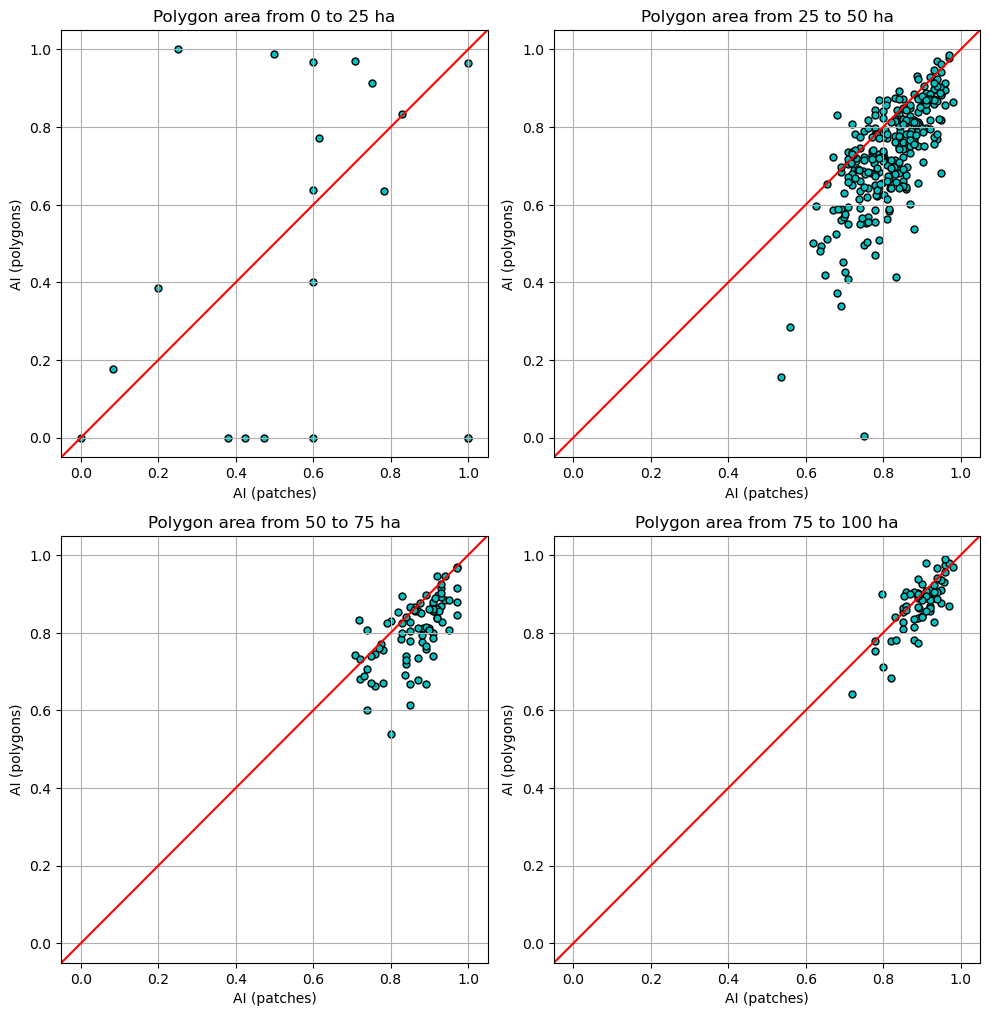

In [40]:
# Here, the study of the correlation for different class of polygon size is performed
# the data used for that purpose is Fuel Category 4
# Plot the AI of patches vs the AI of polygons

import matplotlib.lines as mlines

plt.subplots(figsize = (10,25))

# Range tested: 0 to 25 ha
Fuel4_Range1 = AI_patch_poly_Fuel4.loc[(0<AI_patch_poly_Fuel4['Area_Ha']) & (AI_patch_poly_Fuel4['Area_Ha']<=25) ]

plt. subplot(5,2,1)
x1 = Fuel4_Range1['AI (patch)']
y1 = Fuel4_Range1['AI']
plt.scatter(x1, y1, color = 'c', edgecolor = 'black', marker='.', s= 100)
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.axline([0,0], slope =1, color ='red')
plt.title('Polygon area from 0 to 25 ha')
plt.xlabel('AI (patches)')
plt.ylabel('AI (polygons)')
plt.grid()

# Range tested: 25 to 50 ha
Fuel4_Range2 = AI_patch_poly_Fuel4.loc[(25<AI_patch_poly_Fuel4['Area_Ha']) & (AI_patch_poly_Fuel4['Area_Ha']<=50) ]

plt. subplot(5,2,2)
x2 = Fuel4_Range2['AI (patch)']
y2 = Fuel4_Range2['AI']
plt.scatter(x2, y2, color = 'c', edgecolor = 'black', marker='.', s = 100)
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.axline([0,0], slope =1, color = 'red')
plt.title('Polygon area from 25 to 50 ha')
plt.xlabel('AI (patches)')
plt.ylabel('AI (polygons)')
plt.grid()

# Range tested: 50 to 75 ha
Fuel4_Range3 = AI_patch_poly_Fuel4.loc[(50<AI_patch_poly_Fuel4['Area_Ha']) & (AI_patch_poly_Fuel4['Area_Ha']<=75) ]

plt. subplot(5,2,3)
x3 = Fuel4_Range3['AI (patch)']
y3 = Fuel4_Range3['AI']
plt.scatter(x3, y3, color = 'c', edgecolor = 'black', marker='.', s= 100)
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.axline([0,0], slope =1, color = 'red')
plt.title('Polygon area from 50 to 75 ha')
plt.xlabel('AI (patches)')
plt.ylabel('AI (polygons)')
plt.grid()

# Range tested: 75 to 100 ha
Fuel4_Range4 = AI_patch_poly_Fuel4.loc[(75<AI_patch_poly_Fuel4['Area_Ha']) & (AI_patch_poly_Fuel4['Area_Ha']<=100) ]

plt. subplot(5,2,4)
x4 = Fuel4_Range4['AI (patch)']
y4 = Fuel4_Range4['AI']
plt.scatter(x4, y4, color = 'c', edgecolor = 'black', marker='.', s=100)
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.axline([0,0], slope =1, color='red')
plt.title('Polygon area from 75 to 100 ha')
plt.xlabel('AI (patches)')
plt.ylabel('AI (polygons)')
plt.grid()


plt.tight_layout()

In [41]:
# Here, the Pearson correlation coefficient and the p-Value area obtained for Fuel Category 4
print("Fuel4_Range1:", stats.pearsonr(x1,y1))
print("Fuel4_Range2:", stats.pearsonr(x2,y2))
print("Fuel4_Range3:", stats.pearsonr(x3,y3))
print("Fuel4_Range4:", stats.pearsonr(x4,y4))

Fuel4_Range1: PearsonRResult(statistic=0.23414932585448622, pvalue=0.3204051886012905)
Fuel4_Range2: PearsonRResult(statistic=0.7053877325972928, pvalue=2.1407045403871484e-42)
Fuel4_Range3: PearsonRResult(statistic=0.6400211836683001, pvalue=4.261497686535282e-11)
Fuel4_Range4: PearsonRResult(statistic=0.7619874050406439, pvalue=6.948460267838621e-14)


/tmp/ipykernel_19507/1587553221.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt. subplot(5,2,1)


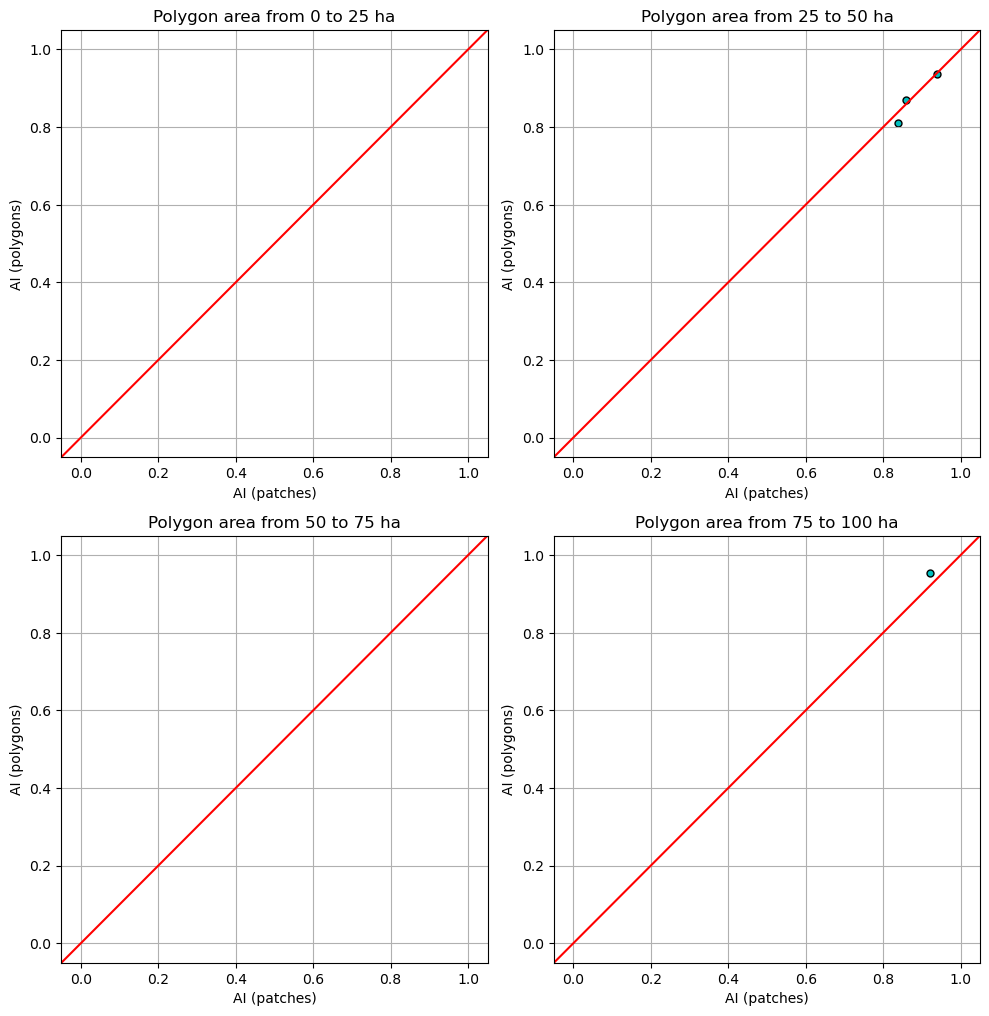

In [42]:
# Here, the study of the correlation for different class of polygon size is performed
# the data used for that purpose is Fuel Category 5
# Plot the AI of patches vs the AI of polygons

import matplotlib.lines as mlines

plt.subplots(figsize = (10,25))

# Range tested: 0 to 25 ha
Fuel5_Range1 = AI_patch_poly_Fuel5.loc[(0<AI_patch_poly_Fuel5['Area_Ha']) & (AI_patch_poly_Fuel5['Area_Ha']<=25) ]

plt. subplot(5,2,1)
x1 = Fuel5_Range1['AI (patch)']
y1 = Fuel5_Range1['AI']
plt.scatter(x1, y1, color = 'c', edgecolor = 'black', marker='.', s= 100)
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.axline([0,0], slope =1, color ='red')
plt.title('Polygon area from 0 to 25 ha')
plt.xlabel('AI (patches)')
plt.ylabel('AI (polygons)')
plt.grid()

# Range tested: 25 to 50 ha
Fuel5_Range2 = AI_patch_poly_Fuel5.loc[(25<AI_patch_poly_Fuel5['Area_Ha']) & (AI_patch_poly_Fuel5['Area_Ha']<=50) ]

plt. subplot(5,2,2)
x2 = Fuel5_Range2['AI (patch)']
y2 = Fuel5_Range2['AI']
plt.scatter(x2, y2, color = 'c', edgecolor = 'black', marker='.', s = 100)
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.axline([0,0], slope =1, color = 'red')
plt.title('Polygon area from 25 to 50 ha')
plt.xlabel('AI (patches)')
plt.ylabel('AI (polygons)')
plt.grid()

# Range tested: 50 to 75 ha
Fuel5_Range3 = AI_patch_poly_Fuel5.loc[(50<AI_patch_poly_Fuel5['Area_Ha']) & (AI_patch_poly_Fuel5['Area_Ha']<=75) ]

plt. subplot(5,2,3)
x3 = Fuel5_Range3['AI (patch)']
y3 = Fuel5_Range3['AI']
plt.scatter(x3, y3, color = 'c', edgecolor = 'black', marker='.', s= 100)
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.axline([0,0], slope =1, color = 'red')
plt.title('Polygon area from 50 to 75 ha')
plt.xlabel('AI (patches)')
plt.ylabel('AI (polygons)')
plt.grid()

# Range tested: 75 to 100 ha
Fuel5_Range4 = AI_patch_poly_Fuel5.loc[(75<AI_patch_poly_Fuel5['Area_Ha']) & (AI_patch_poly_Fuel5['Area_Ha']<=100) ]

plt. subplot(5,2,4)
x4 = Fuel5_Range4['AI (patch)']
y4 = Fuel5_Range4['AI']
plt.scatter(x4, y4, color = 'c', edgecolor = 'black', marker='.', s=100)
plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.axline([0,0], slope =1, color='red')
plt.title('Polygon area from 75 to 100 ha')
plt.xlabel('AI (patches)')
plt.ylabel('AI (polygons)')
plt.grid()


plt.tight_layout()

In [45]:
# Here, the Pearson correlation coefficient and the p-Value area obtained for Fuel Category 5
#print("Fuel5_Range1:", stats.pearsonr(x1,y1))
print("Fuel5_Range2:", stats.pearsonr(x2,y2))
#print("Fuel5_Range3:", stats.pearsonr(x3,y3))
#print("Fuel5_Range4:", stats.pearsonr(x4,y4))

Fuel5_Range2: PearsonRResult(statistic=0.958960926244108, pvalue=0.18301658714471258)


In [46]:
# Estimate the amount of patches and polygons that belong to each category
Cat_Fuel1 =  category(AI_patch_poly_Fuel1)
Cat_Fuel2 =  category(AI_patch_poly_Fuel2)
Cat_Fuel3 =  category(AI_patch_poly_Fuel3)
Cat_Fuel4 =  category(AI_patch_poly_Fuel4)
Cat_Fuel5 =  category(AI_patch_poly_Fuel5)

/tmp/ipykernel_19507/1861115302.py:19: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  ax.set_yscale('Log')
/tmp/ipykernel_19507/1861115302.py:20: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  ax2.set_yscale('Log')
/tmp/ipykernel_19507/1861115302.py:22: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10**4)


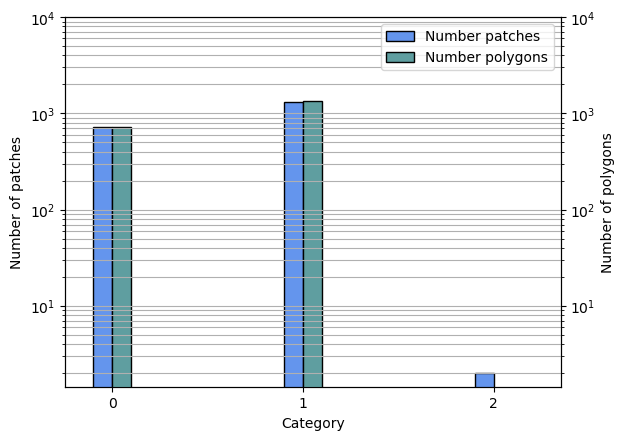

In [47]:
# FUEL 1: Figures of number of patches and polygon per continuity category

fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.1

Cat_Fuel1['Number patches'].plot(kind='bar', color='cornflowerblue', edgecolor='black', ax=ax, width=width, position=1)
Cat_Fuel1['Number polygons'].plot(kind='bar', color='cadetblue', edgecolor='black', ax=ax2, width=width, position=0)

ax.tick_params(axis='x', labelrotation = 0)

ax.set_ylabel('Number of patches')
ax2.set_ylabel('Number of polygons')
ax.set_xlabel('Category')

ax.set_yscale('Log')
ax2.set_yscale('Log')

ax.set_ylim(0, 10**4)
ax2.set_ylim(ax.get_ylim())

fig.legend(loc = 'upper right', bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)

plt.grid(True, axis='y', which = 'both')

plt.show()

/tmp/ipykernel_19507/306645639.py:19: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  ax.set_yscale('Log')
/tmp/ipykernel_19507/306645639.py:20: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  ax2.set_yscale('Log')
/tmp/ipykernel_19507/306645639.py:22: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10**4)


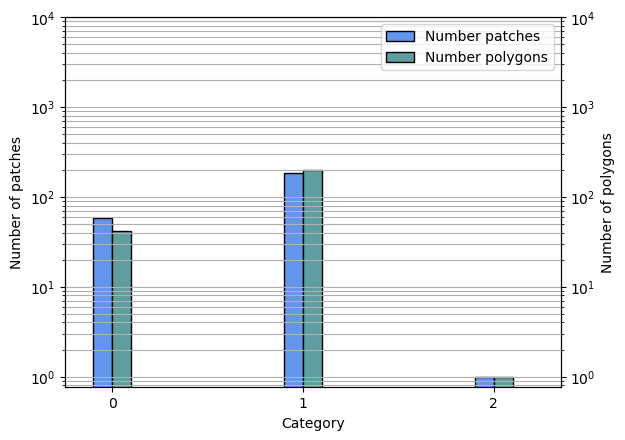

In [48]:
# FUEL 2: Figures of number of patches and polygon per continuity category

fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.1

Cat_Fuel2['Number patches'].plot(kind='bar', color='cornflowerblue', edgecolor='black', ax=ax, width=width, position=1)
Cat_Fuel2['Number polygons'].plot(kind='bar', color='cadetblue', edgecolor='black', ax=ax2, width=width, position=0)

ax.tick_params(axis='x', labelrotation = 0)

ax.set_ylabel('Number of patches')
ax2.set_ylabel('Number of polygons')
ax.set_xlabel('Category')

ax.set_yscale('Log')
ax2.set_yscale('Log')

ax.set_ylim(0, 10**4)
ax2.set_ylim(ax.get_ylim())

fig.legend(loc = 'upper right', bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)

plt.grid(True, axis='y', which = 'both')

plt.show()

/tmp/ipykernel_19507/1078300593.py:19: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  ax.set_yscale('Log')
/tmp/ipykernel_19507/1078300593.py:20: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  ax2.set_yscale('Log')
/tmp/ipykernel_19507/1078300593.py:22: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10**4)


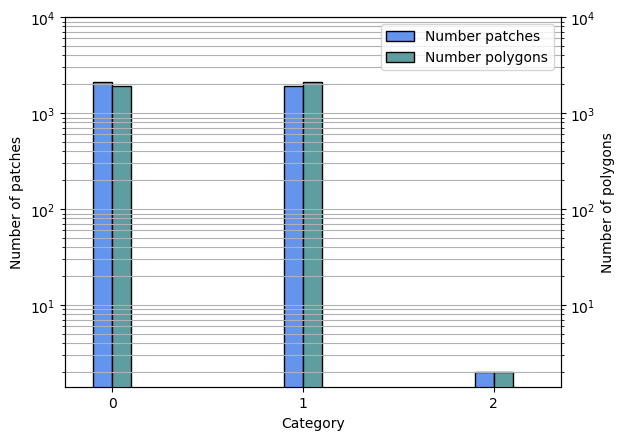

In [49]:
# FUEL 3: Figures of number of patches and polygon per continuity category

fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.1

Cat_Fuel3['Number patches'].plot(kind='bar', color='cornflowerblue', edgecolor='black', ax=ax, width=width, position=1)
Cat_Fuel3['Number polygons'].plot(kind='bar', color='cadetblue', edgecolor='black', ax=ax2, width=width, position=0)

ax.tick_params(axis='x', labelrotation = 0)

ax.set_ylabel('Number of patches')
ax2.set_ylabel('Number of polygons')
ax.set_xlabel('Category')

ax.set_yscale('Log')
ax2.set_yscale('Log')

ax.set_ylim(0, 10**4)
ax2.set_ylim(ax.get_ylim())

fig.legend(loc = 'upper right', bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)

plt.grid(True, axis='y', which = 'both')

plt.show()

/tmp/ipykernel_19507/27247017.py:19: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  ax.set_yscale('Log')
/tmp/ipykernel_19507/27247017.py:20: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  ax2.set_yscale('Log')
/tmp/ipykernel_19507/27247017.py:22: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10**4)


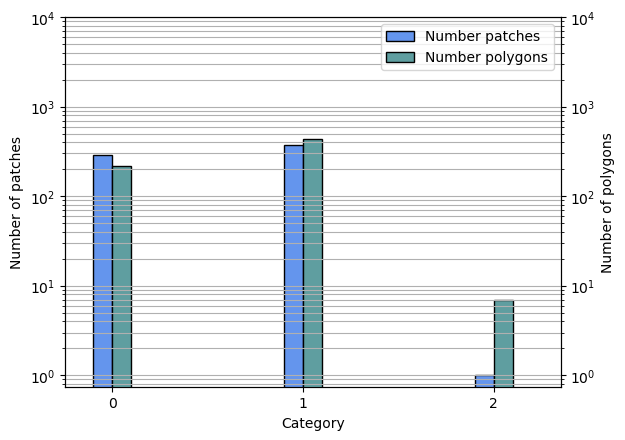

In [50]:
# FUEL 4: Figures of number of patches and polygon per continuity category

fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.1

Cat_Fuel4['Number patches'].plot(kind='bar', color='cornflowerblue', edgecolor='black', ax=ax, width=width, position=1)
Cat_Fuel4['Number polygons'].plot(kind='bar', color='cadetblue', edgecolor='black', ax=ax2, width=width, position=0)

ax.tick_params(axis='x', labelrotation = 0)

ax.set_ylabel('Number of patches')
ax2.set_ylabel('Number of polygons')
ax.set_xlabel('Category')

ax.set_yscale('Log')
ax2.set_yscale('Log')

ax.set_ylim(0, 10**4)
ax2.set_ylim(ax.get_ylim())

fig.legend(loc = 'upper right', bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)

plt.grid(True, axis='y', which = 'both')

plt.show()

/tmp/ipykernel_19507/2017747482.py:19: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  ax.set_yscale('Log')
/tmp/ipykernel_19507/2017747482.py:20: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  ax2.set_yscale('Log')
/tmp/ipykernel_19507/2017747482.py:22: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 10**4)


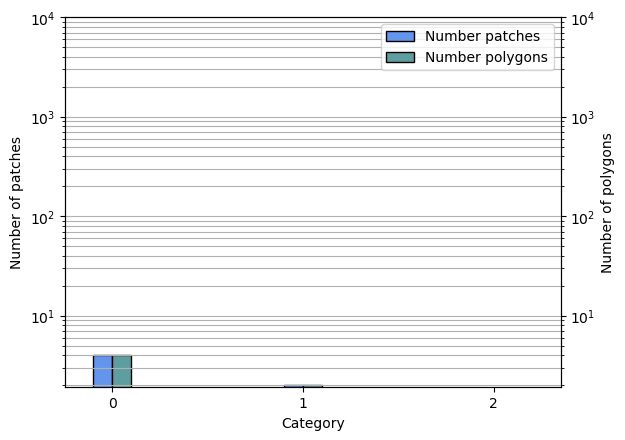

In [51]:
# FUEL 5: Figures of number of patches and polygon per continuity category

fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.1

Cat_Fuel5['Number patches'].plot(kind='bar', color='cornflowerblue', edgecolor='black', ax=ax, width=width, position=1)
Cat_Fuel5['Number polygons'].plot(kind='bar', color='cadetblue', edgecolor='black', ax=ax2, width=width, position=0)

ax.tick_params(axis='x', labelrotation = 0)

ax.set_ylabel('Number of patches')
ax2.set_ylabel('Number of polygons')
ax.set_xlabel('Category')

ax.set_yscale('Log')
ax2.set_yscale('Log')

ax.set_ylim(0, 10**4)
ax2.set_ylim(ax.get_ylim())

fig.legend(loc = 'upper right', bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)

plt.grid(True, axis='y', which = 'both')

plt.show()